In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import json
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import gc
import os
import numpy as np
import evaluate

## Dataset exploration and cleaning
sharc dataset was used to train the classifer model (distilled bert)

In [ ]:


print("--- Starting pre-processing ---")


base_json_path = r"C:\\Users\\Shosh\\Desktop\\Univeristy\\Graduation project\\code\\sharc1-official\\sharc1-official\\json"


train_path = os.path.join(base_json_path, "sharc_train.json")
dev_path = os.path.join(base_json_path, "sharc_dev.json")
output_path = os.path.join(base_json_path, "cleaned_data.jsonl") # New file

print(f"Reading from: {base_json_path}")
print(f"Writing to: {output_path}")


def parse_example(ex):
    """Parses a single example dictionary."""
    user_utt = f"{ex.get('scenario','')} {ex.get('question','')}".strip()
    history = ex.get('history')
    clar_q = None
    if history:
        clar_q = history[0].get('follow_up_question')
    
    return {
        "user_utterance": user_utt,
        "clarify_required": bool(clar_q),
        "clarifying_question": clar_q or ""
    }


with open(output_path, 'w') as outfile:
    print(f"Processing {train_path}...")
    with open(train_path) as f:
        train_data = json.load(f)
    
    for ex in train_data:
        cleaned_ex = parse_example(ex)
        outfile.write(json.dumps(cleaned_ex) + '\n') # Write as one line
    
    del train_data 
    gc.collect() 
    print(f"Finished processing {train_path}.")


with open(output_path, 'a') as outfile:
    print(f"Processing {dev_path}...")
    with open(dev_path) as f:
        dev_data = json.load(f)
        
    for ex in dev_data:
        cleaned_ex = parse_example(ex)
        outfile.write(json.dumps(cleaned_ex) + '\n')
    
    del dev_data
    gc.collect()
    print(f"Finished processing {dev_path}.")

print(f"\n✅ file combination completed. Cleaned data saved to {output_path}")

--- Starting pre-processing ---
Reading from: C:\\Users\\Shosh\\Desktop\\Univeristy\\Graduation project\\code\\sharc1-official\\sharc1-official\\json
Writing to: C:\\Users\\Shosh\\Desktop\\Univeristy\\Graduation project\\code\\sharc1-official\\sharc1-official\\json\cleaned_data.jsonl
Processing C:\\Users\\Shosh\\Desktop\\Univeristy\\Graduation project\\code\\sharc1-official\\sharc1-official\\json\sharc_train.json...
Finished processing C:\\Users\\Shosh\\Desktop\\Univeristy\\Graduation project\\code\\sharc1-official\\sharc1-official\\json\sharc_train.json.
Processing C:\\Users\\Shosh\\Desktop\\Univeristy\\Graduation project\\code\\sharc1-official\\sharc1-official\\json\sharc_dev.json...
Finished processing C:\\Users\\Shosh\\Desktop\\Univeristy\\Graduation project\\code\\sharc1-official\\sharc1-official\\json\sharc_dev.json.

✅ file combination completed. Cleaned data saved to C:\\Users\\Shosh\\Desktop\\Univeristy\\Graduation project\\code\\sharc1-official\\sharc1-official\\json\cleaned_

In [9]:
preprocessed_path = os.path.join(base_json_path, "cleaned_data.jsonl")

print(f"Loading cleaned data from {preprocessed_path}...")
df = pd.read_json(preprocessed_path, lines=True)

print("Data loaded successfully.")


print("\n--- First 5 Rows ---")
df.head(10)

Loading cleaned data from C:\\Users\\Shosh\\Desktop\\Univeristy\\Graduation project\\code\\sharc1-official\\sharc1-official\\json\cleaned_data.jsonl...
Data loaded successfully.

--- First 5 Rows ---


,user_utterance,clarify_required,clarifying_question
0,I am a doctor. It does not involve a municipal...,False,
1,Am I eligible for the Parenting Payment?,True,Is your income under the limits?
2,I have an unconditional offer for a course wit...,True,Do you have an unconditional offer of a place ...
3,I am a 32 year old man from the United States....,True,Are you selling seeds from ornamental plants w...
4,I run a rather large business. According to w...,True,Does the business meet SBA size standards?
5,I have questions about Housing Benefit. My ext...,False,
6,It is a meal. Can I claim this expense?,True,Is it a travel expense to cover your fare if y...
7,"My family is middle class, I'm 35 and I am par...",True,Are you a low-income family?
8,I've been waiting for my check. I don't reall...,True,"Is it 10,000 or less?"
9,I don't have any state benefits. Can this bene...,True,Do you have income support?


In [5]:
# Cell 3: Info & Missing Values

print("--- 1. Column Info (Types & Non-Null Counts) ---")
df.info()

print("\n--- 2. Checking for 'Hidden' Missing Values (Empty Strings) ---")
# Your pre-processing script prevents 'None', but let's check for empty strings.
empty_utterances = (df['user_utterance'] == "").sum()
print(f"Empty 'user_utterance' strings: {empty_utterances}")

# This should be equal to the number of 'False' cases, which is normal.
empty_questions = (df['clarifying_question'] == "").sum()
print(f"Empty 'clarifying_question' strings: {empty_questions}")

--- 1. Column Info (Types & Non-Null Counts) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24160 entries, 0 to 24159
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_utterance       24160 non-null  object
 1   clarify_required     24160 non-null  bool  
 2   clarifying_question  24160 non-null  object
dtypes: bool(1), object(2)
memory usage: 401.2+ KB

--- 2. Checking for 'Hidden' Missing Values (Empty Strings) ---
Empty 'user_utterance' strings: 0
Empty 'clarifying_question' strings: 7645


--- Raw Counts for 'clarify_required' ---
clarify_required
True     16515
False     7645
Name: count, dtype: int64

--- Percentage for 'clarify_required' ---
clarify_required
True     68.356788
False    31.643212
Name: proportion, dtype: float64


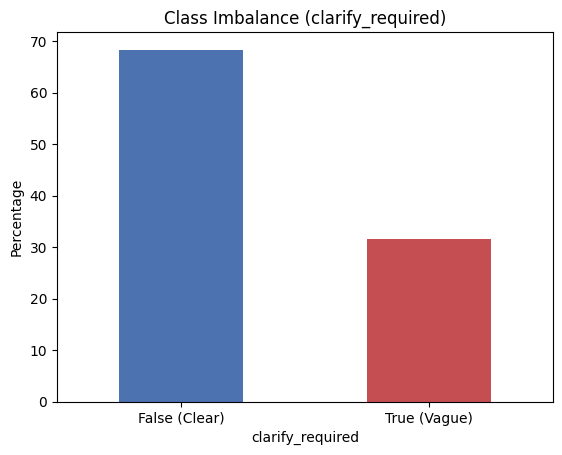

In [6]:
# Cell 4: Class Imbalance

print("--- Raw Counts for 'clarify_required' ---")
print(df['clarify_required'].value_counts())

print("\n--- Percentage for 'clarify_required' ---")
class_percentages = df['clarify_required'].value_counts(normalize=True) * 100
print(class_percentages)

# Optional: Plot a quick bar chart
class_percentages.plot(kind='bar',
                       title='Class Imbalance (clarify_required)',
                       color=['#4C72B0', '#C44E52'])
plt.ylabel('Percentage')
plt.xticks(ticks=[0, 1], labels=['False (Clear)', 'True (Vague)'], rotation=0)
plt.show()

## Training the classifier

In [ ]:
preprocessed_path = os.path.join(base_json_path, "cleaned_data.jsonl") 

# --- 💡 NEW FOLDERS ---
drive_checkpoint_path = "./sharc_distilbert_checkpoints" 
final_model_path = "./sharc_distilbert_final" 
print(f"NEW Classifier will be saved to: {final_model_path}")

# --- 2. Loading Data ---
all_ds = load_dataset('json', data_files=preprocessed_path, split='train')

# --- 3. Preparing Classifier Dataset ---
splits = all_ds.train_test_split(test_size=0.2, seed=42)
clf_train_ds = splits['train'].map(
    lambda x: {"labels": int(x["clarify_required"])},
    load_from_cache_file=False
)
clf_valid_ds = splits['test'].map(
    lambda x: {"labels": int(x["clarify_required"])},
    load_from_cache_file=False
)
del all_ds, splits
gc.collect()


model_name = "distilbert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(batch["user_utterance"], truncation=True, max_length=128)

tokenized_train_ds = clf_train_ds.map(
    tokenize_fn, batched=True, remove_columns=["user_utterance", "clarifying_question", "clarify_required"]
)
tokenized_valid_ds = clf_valid_ds.map(
    tokenize_fn, batched=True, remove_columns=["user_utterance", "clarifying_question", "clarify_required"]
)
del clf_train_ds, clf_valid_ds
gc.collect()

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


training_args = TrainingArguments(
    output_dir=drive_checkpoint_path,
    num_train_epochs=5, 
    per_device_train_batch_size=4, 
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4, 
    no_cuda=True, 
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    load_best_model_at_end=True,
    save_total_limit=2
)
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_valid_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
# --- 7. Start/Resume Training ---
print("\n--- Starting/Resuming Training (DistilBERT) ---")
trainer.train()

# --- 8. Save the Final Model ---
print(f"\n--- Training Complete. Saving final model to {final_model_path} ---")
trainer.save_model(final_model_path)
print("✅ *NEW* Classifier training complete.")

## Language Agent 

In [16]:
# ==========================================================
# 🤖 SMART LANGUAGE AGENT (Context-Agnostic + Human-like Clarifications)
# ==========================================================
from transformers import pipeline, AutoTokenizer
import torch
import os
import re
import random
import json
import uuid
import time

# --- 1. Load Classifier ---
classifier_path = "./sharc_distilbert_final"
classifier_path_abs = os.path.abspath(classifier_path)
print(f"Loading classifier from: {classifier_path_abs}")
classifier = pipeline("text-classification", model=classifier_path_abs)
print("✅ Classifier loaded.")

# --- 2. Load Reasoning Model ---
reasoning_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
print(f"Loading {reasoning_model_name}...")
tokenizer = AutoTokenizer.from_pretrained(reasoning_model_name)
reasoner = pipeline(
    "text-generation",
    model=reasoning_model_name,
    tokenizer=tokenizer,
    model_kwargs={"device_map": "auto", "torch_dtype": torch.float32}
)
print("✅ Reasoner loaded.")

# ==========================================================
# 3. Conversation History Manager
# ==========================================================
class ConversationHistory:
    def __init__(self):
        self.messages = []  # full chat turns if you want to expand
        self.original_task = None
        self.clarifications = []  # list of dicts {question, answer}
        self.entities_mentioned = {}
        self.questions_asked = set()
        self.last_question = None

    def set_original_task(self, task):
        self.original_task = task
        self._extract_entities(task)

    def add_clarification(self, question, answer):
        self.clarifications.append({"question": question, "answer": answer})
        self._extract_entities(answer)

    def set_last_question(self, q):
        self.last_question = q

    def mark_question_asked(self, q_type):
        self.questions_asked.add(q_type)

    def get_full_context(self):
        context = f"Task: {self.original_task}\n"
        if self.clarifications:
            context += "Clarifications:\n"
            for i, c in enumerate(self.clarifications, 1):
                context += f"{i}. Q: {c['question']} A: {c['answer']}\n"
        return context

    def _extract_entities(self, text):
        """Extract general-purpose task entities (conservative)."""
        t = (text or "").lower()

        # ACTION - conservative mapping, default 'other'
        if re.search(r"\b(save|store|download|save as|archive)\b", t):
            self.entities_mentioned["action"] = "save"
        elif re.search(r"\b(open|launch|start)\b", t):
            self.entities_mentioned["action"] = "open_app"
        elif re.search(r"\b(delete|remove)\b", t):
            self.entities_mentioned["action"] = "delete"
        elif re.search(r"\b(calculate|compute|sum|evaluate|what is)\b", t):
            self.entities_mentioned["action"] = "calculate"
        elif re.search(r"\b(search|find|lookup)\b", t):
            self.entities_mentioned["action"] = "search"
        else:
            # keep 'other' until clarified
            self.entities_mentioned.setdefault("action", "other")

        # App / File Detection - conservative
        app_match = re.search(r"\b(spotify|chrome|calculator|word|excel|notepad|zoom|vscode|vs code|photoshop|sublime|edge|firefox)\b", t)
        if app_match:
            self.entities_mentioned["app_name"] = app_match.group()

        # filename detection
        file_match = re.search(r"([\w\-\s]+?\.(?:pdf|docx?|xlsx?|pptx?|txt|csv))", text or "", flags=re.IGNORECASE)
        if file_match:
            self.entities_mentioned["filename"] = file_match.group(1).strip()

        # detect if user mentions "from website" or "from site" or url
        if re.search(r"\b(website|webpage|page|url|http://|https://)\b", t):
            self.entities_mentioned["context"] = "web"
        elif re.search(r"\b(file|document|local|desktop|folder|drive|c:\\|/home/)\b", t):
            self.entities_mentioned["context"] = "local"
        else:
            # preserve existing context if set, otherwise general
            self.entities_mentioned.setdefault("context", "general")

        # detect location/destination mention
        if re.search(r"\b(desktop|downloads|documents|folder|google drive|dropbox|s3|database)\b", t):
            self.entities_mentioned["destination_hint"] = re.search(r"\b(desktop|downloads|documents|folder|google drive|dropbox|s3|database)\b", t).group()

        # expression detection for calculations
        expr_match = re.search(r"([\d\.\+\-\*/\^\(\)\s]+)$", text or "")
        if expr_match and len(expr_match.group(1).strip()) > 0:
            self.entities_mentioned["expression"] = expr_match.group(1).strip()

    def get_missing_info(self):
        """Return list of missing info slots that matter for the detected action/context."""
        missing = []
        action = self.entities_mentioned.get("action", "")
        ctx = self.entities_mentioned.get("context", "")

        # For save: we need WHAT and WHERE and SOURCE
        if action == "save":
            # What to save
            if "filename" not in self.entities_mentioned and "what_to_save" not in self.questions_asked:
                missing.append("what_to_save")
            # Source (web/local/app)
            if ctx == "general" and "source_type" not in self.questions_asked:
                # unknown source (web/local/app)
                missing.append("source_type")
            # Where to save / destination
            if "destination_hint" not in self.entities_mentioned and "destination" not in self.questions_asked:
                missing.append("destination")
        # For open_app: need app_name
        if action == "open_app":
            if "app_name" not in self.entities_mentioned and "app_name" not in self.questions_asked:
                missing.append("app_name")
        # For download/search: need target or query
        if action == "search":
            if "search_term" not in self.entities_mentioned and "search_term" not in self.questions_asked:
                missing.append("search_term")
        # For calculate
        if action == "calculate":
            if "expression" not in self.entities_mentioned and "expression" not in self.questions_asked:
                missing.append("expression")

        # If action unknown and hasn't been clarified
        if action == "other" and "clarify_action" not in self.questions_asked:
            missing.insert(0, "clarify_action")

        return missing

    def reset(self):
        self.__init__()

# ==========================================================
# 4. Clarifying Question Generator (LLM-driven, one question at a time)
# ==========================================================
def generate_clarifying_question_llm(history):
    """
    Use the reasoner LLM to produce a single human-like clarifying question
    tailored to the current missing info and context. Returns the question string.
    """

    missing = history.get_missing_info()
    # If nothing missing, return None
    if not missing:
        return None

    # Prepare a succinct prompt describing only concrete facts and the missing slot(s).
    facts = {
        "original_task": history.original_task,
        "entities": history.entities_mentioned,
        "clarifications_so_far": history.clarifications,
        "missing_slots": missing
    }

    # Build a short directed prompt asking the LLM to produce a single concise natural question.
    # Instruction: produce one direct, human-like question suitable to ask the user next.
    prompt = (
        "You are a helpful assistant that asks exactly one clear, polite follow-up question to "
        "clarify a user's instruction so an automation agent can proceed. "
        "Do NOT provide a list. Produce a single question only (one line), phrased naturally as if a human asked it.\n\n"
        f"Facts:\n{json.dumps(facts, indent=2)}\n\n"
        "Produce ONE clarifying question (end with a question mark). Keep it short and specific. "
        "Do not add any explanation or multiple questions."
    )

    # Call the reasoner deterministically (low temp, no sampling)
    try:
        resp = reasoner(prompt, max_new_tokens=64, do_sample=False, temperature=0.0, top_p=0.9)
        raw = resp[0]["generated_text"]
        # The model may echo the prompt; get the tail
        tail = raw.split(prompt)[-1].strip()
        # Extract the first line that ends with '?' or the first sentence.
        # Search for first occurrence of '?' and take until that point.
        qm_idx = tail.find('?')
        if qm_idx != -1:
            question = tail[:qm_idx+1].strip().replace('\n', ' ')
        else:
            # fallback: first line
            first_line = tail.splitlines()[0].strip() if tail.splitlines() else tail.strip()
            question = first_line if first_line.endswith('?') else first_line + '?'
        # sanitize: avoid overly long
        if len(question) > 200:
            question = question[:197].rsplit(' ', 1)[0] + '?'
    except Exception:
        question = None

    # Last-resort fallback to a polite generic single question
    if not question or len(question.strip()) == 0:
        # Choose a slot-specific fallback if possible
        slot = missing[0]
        fallbacks = {
            "what_to_save": "What exactly would you like me to save?",
            "source_type": "Is the content from a website or a local file?",
            "destination": "Where should I save it (e.g., Desktop, Downloads, or a specific folder)?",
            "clarify_action": "Could you tell me what you want me to do with this — save, open, delete, or something else?",
            "app_name": "Which application should I open?",
            "search_term": "What should I search for?",
            "expression": "What's the expression you want me to calculate?"
        }
        question = fallbacks.get(slot, "Could you clarify what you mean?")

    # Mark that we've asked about that missing slot (to avoid repetition)
    # Use the slot name to track which question we asked
    history.mark_question_asked(missing[0])
    history.set_last_question(question)
    return question

# ==========================================================
# 5. Task Decomposition + JSON Output (LLM-assisted decomposition)
# ==========================================================
def decompose_task(history):
    """Generate clear, assumption-free reasoning and structured step-by-step plan."""

    full_context = history.get_full_context().strip()
    action = history.entities_mentioned.get("action", "other")
    context = history.entities_mentioned.get("context", "general")

    # Build a strict reasoning prompt that forbids assumptions and extra conversions
    system_prompt = (
        "You are a reasoning assistant for a SMART AUTOMATION AGENT.\n"
        "Your job: explain HOW to perform the user’s requested action, step by step.\n"
        "Rules:\n"
        "1. Use only the facts provided in context or clarifications. Do NOT assume anything unmentioned.\n"
        "2. Do NOT invent extra conversions, new files, apps, or redundant steps.\n"
        "3. The steps should describe HOW to do the task — for example, user interface actions like 'Open file', 'Go to File > Save As', etc.\n"
        "4. Keep it short (5–10 numbered steps max). No looping or repetition.\n"
        "5. Focus on the user’s requested direction — not the opposite (e.g., if saving Word → PDF, do NOT go PDF → Word).\n"
        "6. If something is unclear or missing, skip it or mark it as [NEEDS INFO] instead of assuming.\n"
        "\nOutput format:\n"
        "Reasoning (2–5 concise sentences)\n"
        "Numbered Steps (1 per line, max 10)\n"
    )

    prompt = f"{system_prompt}\n\nFacts:\n{full_context}\n\nGenerate your reasoning and step list now."

    # Generate deterministic reasoning
    try:
        resp = reasoner(
            prompt,
            max_new_tokens=350,
            do_sample=False,
            temperature=0.1,
            top_p=0.9,
        )
        raw = resp[0]["generated_text"]
        tail = raw.split(prompt)[-1].strip()
        llm_output = tail
    except Exception:
        llm_output = (
            "Reasoning: Based on provided info, the agent will perform the save action without assumptions.\n\n"
            "1. Identify the file or content to save.\n"
            "2. Open it in its respective application.\n"
            "3. Use 'File > Save As' and select the required format (e.g., PDF).\n"
            "4. Choose the destination folder (e.g., Desktop).\n"
            "5. Confirm and complete the save operation."
        )

    # 🔧 Post-process hallucinated or repeated steps
    lines = llm_output.splitlines()
    unique_steps = []
    seen = set()
    for line in lines:
        if re.match(r"^\d+\.", line.strip()):
            normalized = re.sub(r"\s+", " ", line.strip().lower())
            if normalized not in seen:
                seen.add(normalized)
                unique_steps.append(line)
        else:
            # keep reasoning part
            unique_steps.append(line)
    llm_output = "\n".join(unique_steps)

    print("\n🧩 LLM Reasoning & Task Decomposition:")
    print(llm_output)
    print()

    # Detect strategy
    if context in ("local", "file"):
        strategy = "local"
    elif context == "web":
        strategy = "web"
    else:
        strategy = "manual"

    # --- 🆕 Detect and include action_type ---
    # Try to infer the intended task goal from the user input
    original_text = history.original_task.lower()
    if "save" in original_text and "pdf" in original_text:
        action_type = "save to pdf"
    elif "convert" in original_text:
        action_type = "convert file"
    elif "open" in original_text:
        action_type = "open file"
    elif "delete" in original_text:
        action_type = "delete file"
    elif "rename" in original_text:
        action_type = "rename file"
    else:
        action_type = action  # fallback, e.g., "other"

    # Build params
    params = {"action_type": action_type}
    for key in ("app_name", "filename", "destination_hint", "expression"):
        if key in history.entities_mentioned:
            params[key] = history.entities_mentioned[key]
    params.setdefault("original_text", history.original_task)

    json_plan = {
        "action": action,
        "context": context,
        "strategy": strategy,
        "params": params,
        "task_id": ""  # must stay blank
    }

    # Save output
    os.makedirs("output_logs", exist_ok=True)
    fname = f"output_logs/plan_{int(time.time())}_{str(uuid.uuid4())[:8]}.json"
    with open(fname, "w", encoding="utf-8") as f:
        json.dump({"llm_reasoning": llm_output, "llm_json_output": json_plan}, f, indent=2)

    print("📦 Final JSON plan (task_id left blank):")
    print(json.dumps(json_plan, indent=2))
    print(f"\n📁 Saved reasoning+plan to: {fname}")

    return llm_output, json_plan, fname



# ==========================================================
# 6. Interaction Loop (Human-like one-question-at-a-time)
# ==========================================================
print("\n" + "=" * 70)
print("🤖 SMART LANGUAGE AGENT - Ready!")
print("=" * 70)
print("I will ask one clear follow-up question at a time when needed — like a human.\n"
      "When all info is present I will show the LLM reasoning and the JSON plan (task_id left empty).")
print("Type 'quit' to exit, 'reset' to start over.\n")

history = ConversationHistory()
in_clarification = False

while True:
    try:
        if not in_clarification:
            user_input = input("\n👤 You: ").strip()
            if user_input.lower() == "quit":
                print("\n👋 Goodbye!")
                break
            if user_input.lower() == "reset":
                history.reset()
                in_clarification = False
                print("✅ Reset complete.")
                continue
            if not user_input:
                continue

            # Set original task and extract entities
            history.set_original_task(user_input)
            classification = classifier(user_input)[0]  # you may use label if needed

            # Decide whether we need clarification
            missing = history.get_missing_info()
            # Also treat ambiguous wording as missing even when slots are empty
            # e.g., "save this" should lead to a question
            # generate single human-like question using LLM
            if missing:
                question = generate_clarifying_question_llm(history)
                # Print the single question (natural tone)
                print(f"\n💬 Agent: {question}")
                in_clarification = True
                continue
            else:
                # No missing slots; still run a quick ambiguity check:
                # if action is 'other' or context 'general' -> ask a targeted Q
                action = history.entities_mentioned.get("action", "other")
                context = history.entities_mentioned.get("context", "general")
                ambiguous = (action == "other" or context == "general")
                # Also check for vague pronouns
                if re.search(r"\b(this|that|it|there|here|those|these)\b", user_input.lower()):
                    ambiguous = True

                if ambiguous:
                    question = generate_clarifying_question_llm(history)
                    print(f"\n💬 Agent: {question}")
                    in_clarification = True
                    continue

                # Otherwise we have enough explicit info -> decompose & output
                print("\n💬 Agent: I have enough information — generating plan...\n")
                llm_reasoning, plan, path = decompose_task(history)
                # after producing plan, reset for next turn
                history.reset()
                in_clarification = False
                continue

        else:
            # in clarification mode - user answered the last single question
            answer = input("\n👤 You: ").strip()
            if answer.lower() == "quit":
                print("\n👋 Goodbye!")
                break
            if answer.lower() == "reset":
                history.reset()
                in_clarification = False
                print("✅ Reset complete.")
                continue
            if not answer:
                continue

            # record clarification and re-evaluate
            history.add_clarification(history.last_question, answer)

            # Recompute missing slots
            missing = history.get_missing_info()
            if missing:
                # generate next single human-like question
                question = generate_clarifying_question_llm(history)
                print(f"\n💬 Agent: {question}")
                in_clarification = True
                continue
            else:
                # All required info collected -> decompose plan
                print("\n💬 Agent: Thanks — I have what I need. Generating plan...\n")
                llm_reasoning, plan, path = decompose_task(history)
                history.reset()
                in_clarification = False
                continue

    except KeyboardInterrupt:
        print("\n\n👋 Interrupted. Goodbye!")
        break
    except Exception as e:
        print(f"\n⚠️ Unexpected error: {e}")
        # don't crash; reset and continue
        history.reset()
        in_clarification = False
        continue


Loading classifier from: c:\Users\Shosh\Desktop\Univeristy\Graduation project\code\sharc_distilbert_final


Device set to use cpu


✅ Classifier loaded.
Loading TinyLlama/TinyLlama-1.1B-Chat-v1.0...


Some parameters are on the meta device because they were offloaded to the cpu and disk.
Device set to use cpu


✅ Reasoner loaded.

🤖 SMART LANGUAGE AGENT - Ready!
I will ask one clear follow-up question at a time when needed — like a human.
When all info is present I will show the LLM reasoning and the JSON plan (task_id left empty).
Type 'quit' to exit, 'reset' to start over.


💬 Agent: Example: "What type of file do you want to save?

💬 Agent: Thanks — I have what I need. Generating plan...


🧩 LLM Reasoning & Task Decomposition:
[NEEDS INFO]

1. Open the word document
2. Go to File > Save As
3. Choose PDF as the format
4. Save the file in your desktop

[NEEDS INFO]

1. Go to File > Save As
2. Choose PDF as the format
3. Save the file in your desktop

[NEEDS INFO]


[NEEDS INFO]


[NEEDS INFO]


[NEEDS INFO]


[NEEDS INFO]


[NEEDS INFO]


[NEEDS INFO]


📦 Final JSON plan (task_id left blank):
{
  "action": "save",
  "context": "local",
  "strategy": "local",
  "params": {
    "action_type": "save",
    "app_name": "word",
    "destination_hint": "desktop",
    "original_text": "save this"
  

In [ ]:
# ==========================================================
# 🤖 SMART LANGUAGE AGENT - No Classifier (Anti-Hallucination)
# ==========================================================
from transformers import pipeline, AutoTokenizer
import torch
import os
import re
import json
import uuid
import time

# --- Load Reasoning Model ---
reasoning_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
print(f"Loading {reasoning_model_name}...")
tokenizer = AutoTokenizer.from_pretrained(reasoning_model_name)
reasoner = pipeline(
    "text-generation",
    model=reasoning_model_name,
    tokenizer=tokenizer,
    model_kwargs={"device_map": "auto", "torch_dtype": torch.float32}
)
print("✅ Reasoner loaded.")

# ==========================================================
# Few-Shot Examples for Question Generation
# ==========================================================
FEW_SHOT_EXAMPLES = """Example 1:
User: "save this"
Missing: what_to_save, source_context, destination
Question: "What would you like me to save? Is it something currently open on your screen, a file on your computer, or content from a website?"

Example 2:
User: "open chrome"
Missing: (nothing)
Question: (none needed)

Example 3:
User: "save the document to desktop"
Missing: source_context, file_format
Question: "Is this document already open in an application, or should I look for it first? Also, what format should I save it as?"

Example 4:
User: "help with my math assignment"
Missing: where_to_find, specific_assignment
Question: "Where can I find this assignment - is it on Moodle, Canvas, or somewhere else? And which assignment is it?"

Example 5:
User: "send a message"
Missing: platform, recipient
Question: "Which platform should I use - Discord, WhatsApp, or something else? And who should I send it to?"
"""

# ==========================================================
# Conversation History Manager (Rule-Based Entity Extraction)
# ==========================================================
class ConversationHistory:
    def __init__(self):
        self.messages = []
        self.original_task = None
        self.clarifications = []
        self.entities_mentioned = {}
        self.questions_asked = set()
        self.last_question = None

    def set_original_task(self, task):
        self.original_task = task
        self._extract_entities(task)

    def add_clarification(self, question, answer):
        self.clarifications.append({"question": question, "answer": answer})
        self._extract_entities(answer)

    def set_last_question(self, q):
        self.last_question = q

    def mark_question_asked(self, q_type):
        self.questions_asked.add(q_type)

    def get_full_context(self):
        context = f"Original request: {self.original_task}\n"
        if self.clarifications:
            context += "Information gathered:\n"
            for i, c in enumerate(self.clarifications, 1):
                context += f"  {i}. Q: {c['question']}\n     A: {c['answer']}\n"
        return context

    def _extract_entities(self, text):
        """Extract task-relevant entities from text using reliable regex patterns."""
        if not text:
            return
            
        t = text.lower()
        original_text = text  # Keep original for case-sensitive matches

        # ===== ACTION DETECTION =====
        action_patterns = {
            "save": r"\b(save|store|download|export|save as)\b",
            "open": r"\b(open|launch|start|run)\b(?!\s+application)",  # Avoid "open application" false positive
            "delete": r"\b(delete|remove|erase|trash)\b",
            "send_message": r"\b(send|message|text|dm|post)\b",
            "search": r"\b(search|find|lookup|locate)\b",
            "solve": r"\b(solve|help|help with|do|complete|work on)\b.*\b(assignment|homework|problem|exercise|quiz|test)\b",
            "convert": r"\b(convert|transform|change|make into)\b",
            "calculate": r"\b(calculate|compute)\b.*[\d\+\-\*/]",
            "browse": r"\b(browse|surf|go to|visit)\b"
        }
        
        for action, pattern in action_patterns.items():
            if re.search(pattern, t):
                self.entities_mentioned["action"] = action
                break
        
        # ===== VAGUE REFERENCE DETECTION =====
        # Critical: "save this", "open that", etc. need clarification
        if re.search(r"\b(this|that|it|there|something)\b", t) and "action" in self.entities_mentioned:
            if self.entities_mentioned["action"] in ["save", "open", "convert", "delete"]:
                self.entities_mentioned["has_vague_reference"] = True
        
        # ===== SOURCE CONTEXT =====
        if re.search(r"\b(currently open|open file|current|active window|on screen|on my screen)\b", t):
            self.entities_mentioned["source_context"] = "open_application"
        elif re.search(r"\b(website|webpage|web page|browser|online|url|http)\b", t):
            self.entities_mentioned["source_context"] = "web"
        elif re.search(r"\b(file|document|folder|directory|desktop|downloads|my pc|computer|entire pc)\b", t):
            self.entities_mentioned["source_context"] = "local_file"
        
        # ===== APPLICATION DETECTION =====
        app_patterns = {
            "word": r"\b(word|winword|microsoft word|ms word)\b",
            "excel": r"\b(excel|ms excel|microsoft excel)\b",
            "powerpoint": r"\b(powerpoint|ppt|ms powerpoint)\b",
            "notepad": r"\b(notepad)\b",
            "chrome": r"\b(chrome|google chrome)\b",
            "firefox": r"\b(firefox|mozilla)\b",
            "edge": r"\b(edge|microsoft edge)\b",
            "calculator": r"\b(calculator|calc)\b",
            "spotify": r"\b(spotify)\b",
            "discord": r"\b(discord)\b",
            "whatsapp": r"\b(whatsapp)\b",
            "moodle": r"\b(moodle)\b",
            "canvas": r"\b(canvas)\b"
        }
        
        for app, pattern in app_patterns.items():
            if re.search(pattern, t):
                self.entities_mentioned["app_name"] = app
                break
        
        # Generic browser/internet (needs clarification which browser)
        if re.search(r"\b(browser|internet)\b", t) and "app_name" not in self.entities_mentioned:
            self.entities_mentioned["needs_browser"] = True

        # ===== FILENAME DETECTION =====
        # Look for files with extensions
        file_match = re.search(r"([\w\-\s]+?\.(?:pdf|docx?|xlsx?|pptx?|txt|csv|png|jpg|jpeg|mp3|mp4|zip))", original_text, flags=re.IGNORECASE)
        if file_match:
            self.entities_mentioned["filename"] = file_match.group(1).strip()
        
        # Named file without extension (e.g., "file called report")
        named_file = re.search(r"\b(?:file|document|assignment|report|project)\s+(?:named|called)\s+([\w\-\s]+)", t)
        if named_file:
            self.entities_mentioned["filename_base"] = named_file.group(1).strip()

        # ===== DESTINATION DETECTION =====
        dest_patterns = {
            "desktop": r"\b(desktop|on desktop|to desktop)\b",
            "downloads": r"\b(downloads|download folder)\b",
            "documents": r"\b(documents|my documents)\b"
        }
        for dest, pattern in dest_patterns.items():
            if re.search(pattern, t):
                self.entities_mentioned["destination"] = dest
                break

        # ===== FILE FORMAT DETECTION (TARGET - what to save AS) =====
        # Be careful: distinguish between source and target format
        format_patterns = {
            "pdf": r"\b(as pdf|to pdf|save as pdf|pdf format|\.pdf)\b",
            "docx": r"\b(as docx|to word|as word document|\.docx)\b",
            "txt": r"\b(as txt|to text|as text file|\.txt)\b",
            "xlsx": r"\b(as xlsx|to excel|as spreadsheet|\.xlsx)\b",
            "png": r"\b(as png|to png|\.png)\b",
            "jpg": r"\b(as jpg|to jpg|as jpeg|\.jpg)\b"
        }
        for fmt, pattern in format_patterns.items():
            if re.search(pattern, t):
                self.entities_mentioned["target_format"] = fmt
                break

        # ===== ACADEMIC/ASSIGNMENT DETECTION =====
        if re.search(r"\b(assignment|homework|problem|exercise|quiz|test|exam|project)\b", t):
            self.entities_mentioned["task_type"] = "assignment"
            
            # Course subject
            course_match = re.search(r"\b(math|mathematics|physics|chemistry|biology|english|history|computer science|cs|programming|calculus|algebra)\b", t, re.IGNORECASE)
            if course_match:
                self.entities_mentioned["subject"] = course_match.group(1)
            
            # Platform (Moodle, Canvas, etc.)
            platform_patterns = {
                "moodle": r"\b(moodle)\b",
                "canvas": r"\b(canvas)\b",
                "blackboard": r"\b(blackboard)\b",
                "google_classroom": r"\b(google classroom|classroom)\b"
            }
            for platform, pattern in platform_patterns.items():
                if re.search(pattern, t):
                    self.entities_mentioned["platform"] = platform
                    break

        # ===== MESSAGING PLATFORM =====
        if re.search(r"\b(discord)\b", t):
            self.entities_mentioned["messaging_platform"] = "discord"
        elif re.search(r"\b(whatsapp)\b", t):
            self.entities_mentioned["messaging_platform"] = "whatsapp"
        
        # MESSAGE RECIPIENT
        recipient_match = re.search(r"\b(?:to|message|dm)\s+([\w\s]+?)(?:\s+on|\s+channel|$)", t)
        if recipient_match:
            self.entities_mentioned["recipient"] = recipient_match.group(1).strip()
        
        # MESSAGE CONTENT
        msg_match = re.search(r"(?:say|message|text|send)\s+['\"](.+?)['\"]", original_text, re.IGNORECASE)
        if msg_match:
            self.entities_mentioned["message_content"] = msg_match.group(1).strip()

        # ===== SEARCH QUERY =====
        search_match = re.search(r"(?:search for|find|lookup|locate)\s+(.+?)(?:\s+in|\s+on|$)", original_text, re.IGNORECASE)
        if search_match:
            self.entities_mentioned["search_query"] = search_match.group(1).strip()

        # ===== EXPRESSION FOR CALCULATION =====
        expr_match = re.search(r"([\d\.\+\-\*/\^\(\)\s]+)$", text or "")
        if expr_match and len(expr_match.group(1).strip()) > 2:
            self.entities_mentioned["expression"] = expr_match.group(1).strip()

    def get_missing_info(self):
        """Determine what critical information is still missing (RULE-BASED - NO LLM)."""
        missing = []
        action = self.entities_mentioned.get("action")

        # If action unclear, prioritize that
        if not action:
            if "clarify_action" not in self.questions_asked:
                return ["clarify_action"]
            return []

        # ===== ACTION-SPECIFIC REQUIREMENTS =====
        if action == "save":
            # Need: WHAT, SOURCE, DESTINATION, FORMAT
            # Check for vague reference first
            if self.entities_mentioned.get("has_vague_reference") and "what_to_save" not in self.questions_asked:
                missing.append("what_to_save")
            elif "filename" not in self.entities_mentioned and "filename_base" not in self.entities_mentioned and "what_to_save" not in self.questions_asked:
                missing.append("what_to_save")
            
            if "source_context" not in self.entities_mentioned and "source_context" not in self.questions_asked:
                missing.append("source_context")
            
            if "destination" not in self.entities_mentioned and "destination" not in self.questions_asked:
                missing.append("destination")
            
            if "target_format" not in self.entities_mentioned and "target_format" not in self.questions_asked:
                missing.append("target_format")

        elif action == "convert":
            if "filename" not in self.entities_mentioned and "source_file" not in self.questions_asked:
                missing.append("source_file")
            if "source_context" not in self.entities_mentioned and "source_location" not in self.questions_asked:
                missing.append("source_location")
            if "target_format" not in self.entities_mentioned and "target_format" not in self.questions_asked:
                missing.append("target_format")

        elif action == "open":
            # Check if we have app name or filename
            if "app_name" not in self.entities_mentioned and "filename" not in self.entities_mentioned:
                if self.entities_mentioned.get("needs_browser") and "browser_choice" not in self.questions_asked:
                    missing.append("browser_choice")
                elif "what_to_open" not in self.questions_asked:
                    missing.append("what_to_open")

        elif action == "browse":
            if "app_name" not in self.entities_mentioned and "browser_choice" not in self.questions_asked:
                missing.append("browser_choice")
            if "search_query" not in self.entities_mentioned and "browse_target" not in self.questions_asked:
                missing.append("browse_target")

        elif action == "send_message":
            if "messaging_platform" not in self.entities_mentioned and "platform" not in self.questions_asked:
                missing.append("platform")
            if "recipient" not in self.entities_mentioned and "recipient" not in self.questions_asked:
                missing.append("recipient")
            if "message_content" not in self.entities_mentioned and "message_content" not in self.questions_asked:
                missing.append("message_content")

        elif action == "search":
            if "search_query" not in self.entities_mentioned and "filename" not in self.entities_mentioned and "search_query" not in self.questions_asked:
                missing.append("search_query")

        elif action == "solve":
            if "subject" not in self.entities_mentioned and "subject" not in self.questions_asked:
                missing.append("subject")
            if "platform" not in self.entities_mentioned and "app_name" not in self.entities_mentioned and "platform_location" not in self.questions_asked:
                missing.append("platform_location")
            if "task_type" not in self.entities_mentioned and "specific_assignment" not in self.questions_asked:
                missing.append("specific_assignment")

        elif action == "calculate":
            if "expression" not in self.entities_mentioned and "expression" not in self.questions_asked:
                missing.append("expression")

        return missing

    def reset(self):
        self.__init__()

# ==========================================================
# Generate Clarifying Question (LLM with Strong Constraints)
# ==========================================================
def generate_clarifying_question_llm(history):
    """Generate ONE natural, human-like question. Uses LLM but with strict validation."""
    
    missing = history.get_missing_info()
    if not missing:
        return None

    missing_key = missing[0]  # Most important missing piece
    action = history.entities_mentioned.get("action", "task")
    
    # Build simple, focused prompt
    prompt = f"""You are asking a user for missing information. Be brief and natural.

{FEW_SHOT_EXAMPLES}

User wants to: {action}
You need to ask about: {missing_key}

Generate ONE short question (under 30 words) that sounds natural and friendly.

Question:"""

    try:
        resp = reasoner(
            prompt,
            max_new_tokens=50,  # Shorter to avoid rambling
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.5,  # Prevent repetition
            pad_token_id=tokenizer.eos_token_id
        )
        raw = resp[0]["generated_text"]
        
        # Extract question
        if "Question:" in raw:
            question = raw.split("Question:")[-1].strip()
        else:
            question = raw.split('\n')[-1].strip()
        
        # Take only first sentence
        question = question.split('\n')[0].strip()
        question = re.sub(r'\s+', ' ', question)  # Clean whitespace
        question = question.strip('"\'')  # Remove quotes
        
        # Validation
        if not question.endswith('?'):
            question += '?'
        
        # Length check (prevent hallucination)
        if len(question) < 10 or len(question) > 200:
            raise ValueError("Invalid question length")
        
        # Must contain question words
        question_words = ['what', 'where', 'which', 'who', 'how', 'should', 'would', 'is', 'are', 'do']
        if not any(word in question.lower() for word in question_words):
            raise ValueError("Not a proper question")
        
        # Check for repetition (hallucination indicator)
        words = question.lower().split()
        if len(words) != len(set(words)) * 1.5:  # Too many repeated words
            raise ValueError("Repetitive text detected")
        
        history.mark_question_asked(missing_key)
        history.set_last_question(question)
        return question
        
    except Exception as e:
        print(f"[LLM question generation failed: {e}, using template]")
        # FALLBACK TO TEMPLATES (guaranteed no hallucination)
        return get_template_question(missing_key, history)

def get_template_question(missing_key, history):
    """Fallback template questions - guaranteed safe."""
    templates = {
        "clarify_action": "What would you like me to help you with?",
        "what_to_save": "What would you like me to save?",
        "source_context": "Is this something currently open on your screen, a file on your computer, or content from a website?",
        "destination": "Where should I save it - Desktop, Downloads, or Documents?",
        "target_format": "What format should I save it as - PDF, Word document, text file, or something else?",
        "what_to_open": "What would you like me to open?",
        "browser_choice": "Which browser would you like - Chrome, Firefox, or Edge?",
        "browse_target": "What would you like to browse or search for?",
        "platform": "Which messaging app - Discord or WhatsApp?",
        "recipient": "Who should I send the message to?",
        "message_content": "What should the message say?",
        "search_query": "What would you like me to search for?",
        "source_file": "Which file should I convert?",
        "source_location": "Is the file already open, or should I look for it somewhere specific?",
        "subject": "What subject is this assignment for?",
        "platform_location": "Where can I find this assignment - Moodle, Canvas, or somewhere else?",
        "specific_assignment": "Which specific assignment are you working on?",
        "expression": "What calculation do you need?"
    }
    
    question = templates.get(missing_key, "Could you provide more details?")
    history.mark_question_asked(missing_key)
    history.set_last_question(question)
    return question

# ==========================================================
# Task Decomposition and JSON Generation
# ==========================================================
def decompose_and_generate_json(history):
    """Generate reasoning and JSON output for Coordinator Agent."""
    
    entities = history.entities_mentioned
    action = entities.get("action", "unknown")
    
    # Determine JSON context
    source_context = entities.get("source_context", "local_file")
    if source_context == "web" or action == "browse":
        json_context = "web"
    elif action in ["open", "send_message", "calculate"]:
        json_context = "local"
    else:
        json_context = "system"

    # Generate reasoning (simple, rule-based to avoid hallucination)
    reasoning = generate_rule_based_reasoning(entities, history.clarifications)

    print("\n🧠 Task Reasoning:")
    print(reasoning)
    print()

    # Build JSON structure (rule-based)
    json_output = build_json_structure(entities, json_context)
    
    # Save to file
    os.makedirs("output_logs", exist_ok=True)
    timestamp = int(time.time())
    fname = f"output_logs/task_{timestamp}_{str(uuid.uuid4())[:8]}.json"
    
    with open(fname, "w", encoding="utf-8") as f:
        json.dump({
            "conversation": history.get_full_context(),
            "reasoning": reasoning,
            "task_json": json_output
        }, f, indent=2, ensure_ascii=False)

    print("📋 Generated JSON for Coordinator Agent:")
    print(json.dumps(json_output, indent=2))
    print(f"\n💾 Saved to: {fname}\n")

    return reasoning, json_output, fname

def generate_rule_based_reasoning(entities, clarifications):
    """Generate reasoning using RULES (no LLM - no hallucination)."""
    action = entities.get("action", "task")
    
    reasoning_map = {
        "save": f"The agent will save {entities.get('filename', 'the file')} from {entities.get('source_context', 'the source')} to {entities.get('destination', 'the destination')} in {entities.get('target_format', 'the specified format').upper()} format.",
        
        "open": f"The agent will open {entities.get('app_name') or entities.get('filename', 'the specified application')}.",
        
        "solve": f"The agent will access the {entities.get('subject', 'assignment')} from {entities.get('platform', 'the platform')} and provide assistance with solving it.",
        
        "send_message": f"The agent will send a message via {entities.get('messaging_platform', 'the messaging app')} to {entities.get('recipient', 'the recipient')}.",
        
        "search": f"The agent will search for {entities.get('search_query') or entities.get('filename', 'the specified item')}.",
        
        "browse": f"The agent will open {entities.get('app_name', 'the browser')} and navigate to {entities.get('search_query', 'the specified location')}.",
        
        "convert": f"The agent will convert {entities.get('filename', 'the file')} to {entities.get('target_format', 'the target format').upper()} format.",
        
        "calculate": f"The agent will calculate {entities.get('expression', 'the expression')}."
    }
    
    return reasoning_map.get(action, f"The agent will perform the {action} operation based on the provided information.")

def build_json_structure(entities, json_context):
    """Build JSON structure using RULES (no LLM - no hallucination)."""
    
    action = entities.get("action", "unknown")
    
    # Map action to action_type
    action_type_map = {
        "save": "save_as_pdf" if entities.get("target_format") == "pdf" else "save_file",
        "open": "open_app",
        "send_message": "send_message",
        "search": "search",
        "convert": "convert_file",
        "calculate": "calculate",
        "delete": "delete_file",
        "solve": "solve_assignment",
        "browse": "browse_web"
    }
    action_type = action_type_map.get(action, action)

    # Build params based on action
    params = {"action_type": action_type}
    
    if action == "save":
        filename = entities.get("filename") or entities.get("filename_base", "document")
        target_format = entities.get("target_format", "pdf")
        
        # Ensure correct extension
        if not filename.endswith(f".{target_format}"):
            if '.' in filename:
                filename = filename.rsplit('.', 1)[0]
            filename = f"{filename}.{target_format}"
        
        dest = entities.get("destination", "desktop")
        params["file_path"] = f"{{{{{dest}_path}}}}/{filename}"
        params["format"] = target_format
        
        if entities.get("source_context") == "open_application":
            params["source"] = "current_application"
            params["file_type"] = entities.get("app_name", "unknown")
        else:
            params["source"] = "file_system"
            params["file_type"] = entities.get("app_name", "word")
    
    elif action == "solve":
        params["task_type"] = entities.get("task_type", "assignment")
        params["subject"] = entities.get("subject", "")
        params["platform"] = entities.get("platform", "")
    
    elif action == "open":
        if entities.get("app_name"):
            params["app_name"] = entities["app_name"]
        if entities.get("filename"):
            params["file_path"] = entities["filename"]
    
    elif action == "browse":
        params["browser"] = entities.get("app_name", "chrome")
        if entities.get("search_query"):
            params["search_query"] = entities["search_query"]
    
    elif action == "send_message":
        params["platform"] = entities.get("messaging_platform", "")
        params["recipient"] = entities.get("recipient", "")
        params["message"] = entities.get("message_content", "")
    
    elif action == "search":
        params["query"] = entities.get("search_query", entities.get("filename", ""))
    
    elif action == "calculate":
        params["expression"] = entities.get("expression", "")
    
    elif action == "convert":
        params["source_file"] = entities.get("filename", "")
        params["target_format"] = entities.get("target_format", "")

    # Build final JSON
    json_output = {
        "action": action,
        "context": json_context,
        "params": params,
        "task_id": "",
        "depends_on": "",
        "priority": "",
        "timeout": "",
        "retry_count": ""
    }

    return json_output

# ==========================================================
# Main Interaction Loop
# ==========================================================
print("\n" + "=" * 70)
print("🤖 SMART LANGUAGE AGENT")
print("=" * 70)
print("I'll help you complete tasks by asking clear questions when needed.")
print("Type 'quit' to exit, 'reset' to start over.\n")

history = ConversationHistory()
in_clarification = False
max_turns = 10  # Prevent infinite loops
turn_count = 0

while True:
    try:
        if not in_clarification:
            user_input = input("👤 You: ").strip()
            
            if user_input.lower() == "quit":
                print("\n👋 Thanks for using the agent. Goodbye!")
                break
            if user_input.lower() == "reset":
                history.reset()
                turn_count = 0
                print("✅ Conversation reset. Let's start fresh!\n")
                continue
            if not user_input:
                continue

            print(f"\n[User input]: {user_input}")
            
            # Extract entities (rule-based)
            history.set_original_task(user_input)
            turn_count += 1
            
            # Safety check
            if turn_count > max_turns:
                print("\n💬 Agent: I think I need a bit more context. Could you rephrase what you'd like me to do?\n")
                history.reset()
                turn_count = 0
                in_clarification = False
                continue
            
            # Check if clarification needed
            missing = history.get_missing_info()
            
            if missing:
                question = generate_clarifying_question_llm(history)
                print(f"\n💬 Agent: {question}\n")
                in_clarification = True
            else:
                # Enough info - generate plan
                print(f"\n💬 Agent: Got it! Let me prepare that for you...\n")
                reasoning, json_plan, path = decompose_and_generate_json(history)
                history.reset()
                turn_count = 0

        else:
            # In clarification mode
            answer = input("👤 You: ").strip()
            
            if answer.lower() == "quit":
                print("\n👋 Thanks for using the agent. Goodbye!")
                break
            if answer.lower() == "reset":
                history.reset()
                in_clarification = False
                turn_count = 0
                print("✅ Conversation reset. Let's start fresh!\n")
                continue
            if not answer:
                continue

            print(f"\n[User response]: {answer}")
            
            # Record the clarification
            history.add_clarification(history.last_question, answer)
            turn_count += 1
            
            # Safety check
            if turn_count > max_turns:
                print("\n💬 Agent: I think I need a bit more context. Could you rephrase what you'd like me to do?\n")
                history.reset()
                turn_count = 0
                in_clarification = False
                continue
            
            # Check if more info needed
            missing = history.get_missing_info()
            
            if missing:
                question = generate_clarifying_question_llm(history)
                print(f"\n💬 Agent: {question}\n")
            else:
                # All info collected
                print(f"\n💬 Agent: Perfect! I have everything I need. Preparing your task...\n")
                reasoning, json_plan, path = decompose_and_generate_json(history)
                history.reset()
                in_clarification = False
                turn_count = 0

    except KeyboardInterrupt:
        print("\n\n👋 Interrupted. Goodbye!")
        break
    except Exception as e:
        print(f"\n⚠️ Error: {e}")
        print("Let's try again. Please rephrase your request.\n")
        history.reset()
        in_clarification = False
        turn_count = 0

Loading TinyLlama/TinyLlama-1.1B-Chat-v1.0...


Some parameters are on the meta device because they were offloaded to the disk and cpu.
Device set to use cpu


✅ Reasoner loaded.

🤖 SMART LANGUAGE AGENT
I'll help you complete tasks by asking clear questions when needed.
Type 'quit' to exit, 'reset' to start over.


[User input]: save this
[LLM question generation failed: Repetitive text detected, using template]

💬 Agent: What would you like me to save?


[User response]: word document file
[LLM question generation failed: Not a proper question, using template]

💬 Agent: Where should I save it - Desktop, Downloads, or Documents?


[User response]: desktop
[LLM question generation failed: Repetitive text detected, using template]

💬 Agent: What format should I save it as - PDF, Word document, text file, or something else?


[User response]: pdf

💬 Agent: Perfect! I have everything I need. Preparing your task...


🧠 Task Reasoning:
The agent will save the file from local_file to desktop in THE SPECIFIED FORMAT format.

📋 Generated JSON for Coordinator Agent:
{
  "action": "save",
  "context": "system",
  "params": {
    "action_type": "save_fil

In [ ]:
#JANA TEST

# ==========================================================
# 🤖 SMART LANGUAGE AGENT - No Classifier (Anti-Hallucination)
# ==========================================================
import torch
import os
import re
import json
import uuid
import time
import requests

# --- Load Reasoning Model ---
reasoning_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
print(f"Loading {reasoning_model_name}...")
tokenizer = AutoTokenizer.from_pretrained(reasoning_model_name)
reasoner = pipeline(
    "text-generation",
    model=reasoning_model_name,
    tokenizer=tokenizer,
    model_kwargs={"device_map": "auto", "torch_dtype": torch.float32}
)
print("✅ Reasoner loaded.")

# ==========================================================
# Few-Shot Examples for Question Generation
# ==========================================================
FEW_SHOT_EXAMPLES = """Example 1:
User: "save this"
Missing: what_to_save, source_context, destination
Question: "What would you like me to save? Is it something currently open on your screen, a file on your computer, or content from a website?"

Example 2:
User: "open chrome"
Missing: (nothing)
Question: (none needed)

Example 3:
User: "save the document to desktop"
Missing: source_context, file_format
Question: "Is this document already open in an application, or should I look for it first? Also, what format should I save it as?"

Example 4:
User: "help with my math assignment"
Missing: where_to_find, specific_assignment
Question: "Where can I find this assignment - is it on Moodle, Canvas, or somewhere else? And which assignment is it?"

Example 5:
User: "send a message"
Missing: platform, recipient
Question: "Which platform should I use - Discord, WhatsApp, or something else? And who should I send it to?"
"""

# ==========================================================
# Conversation History Manager (Rule-Based Entity Extraction)
# ==========================================================
class ConversationHistory:
    def __init__(self):
        self.messages = []
        self.original_task = None
        self.clarifications = []
        self.entities_mentioned = {}
        self.questions_asked = set()
        self.last_question = None

    def set_original_task(self, task):
        self.original_task = task
        self._extract_entities(task)

    def add_clarification(self, question, answer):
        self.clarifications.append({"question": question, "answer": answer})
        self._extract_entities(answer)

    def set_last_question(self, q):
        self.last_question = q

    def mark_question_asked(self, q_type):
        self.questions_asked.add(q_type)

    def get_full_context(self):
        context = f"Original request: {self.original_task}\n"
        if self.clarifications:
            context += "Information gathered:\n"
            for i, c in enumerate(self.clarifications, 1):
                context += f"  {i}. Q: {c['question']}\n    A: {c['answer']}\n"
        return context

    def _extract_entities(self, text):
        """Extract task-relevant entities from text using reliable regex patterns."""
        if not text:
            return
            
        t = text.lower()
        original_text = text  # Keep original for case-sensitive matches

        # ===== ACTION DETECTION =====
        action_patterns = {
            "save": r"\b(save|store|download|export|save as)\b",
            "open": r"\b(open|launch|start|run)\b(?!\s+application)",  # Avoid "open application" false positive
            "delete": r"\b(delete|remove|erase|trash)\b",
            "send_message": r"\b(send|message|text|dm|post)\b",
            "search": r"\b(search|find|lookup|locate)\b",
            "solve": r"\b(solve|help|help with|do|complete|work on)\b.*\b(assignment|homework|problem|exercise|quiz|test)\b",
            "convert": r"\b(convert|transform|change|make into)\b",
            "calculate": r"\b(calculate|compute)\b.*[\d\+\-\*/]",
            "browse": r"\b(browse|surf|go to|visit)\b"
        }
        
        for action, pattern in action_patterns.items():
            if re.search(pattern, t):
                self.entities_mentioned["action"] = action
                break
        
        # ===== VAGUE REFERENCE DETECTION =====
        # Critical: "save this", "open that", etc. need clarification
        if re.search(r"\b(this|that|it|there|something)\b", t) and "action" in self.entities_mentioned:
            if self.entities_mentioned["action"] in ["save", "open", "convert", "delete"]:
                self.entities_mentioned["has_vague_reference"] = True
        
        # ===== SOURCE CONTEXT =====
        if re.search(r"\b(currently open|open file|current|active window|on screen|on my screen)\b", t):
            self.entities_mentioned["source_context"] = "open_application"
        elif re.search(r"\b(website|webpage|web page|browser|online|url|http)\b", t):
            self.entities_mentioned["source_context"] = "web"
        elif re.search(r"\b(file|document|folder|directory|desktop|downloads|my pc|computer|entire pc)\b", t):
            self.entities_mentioned["source_context"] = "local_file"
        
        # ===== APPLICATION DETECTION =====
        app_patterns = {
            "word": r"\b(word|winword|microsoft word|ms word)\b",
            "excel": r"\b(excel|ms excel|microsoft excel)\b",
            "powerpoint": r"\b(powerpoint|ppt|ms powerpoint)\b",
            "notepad": r"\b(notepad)\b",
            "chrome": r"\b(chrome|google chrome)\b",
            "firefox": r"\b(firefox|mozilla)\b",
            "edge": r"\b(edge|microsoft edge)\b",
            "calculator": r"\b(calculator|calc)\b",
            "spotify": r"\b(spotify)\b",
            "discord": r"\b(discord)\b",
            "whatsapp": r"\b(whatsapp)\b",
            "moodle": r"\b(moodle)\b",
            "canvas": r"\b(canvas)\b"
        }
        
        for app, pattern in app_patterns.items():
            if re.search(pattern, t):
                self.entities_mentioned["app_name"] = app
                break
        
        # Generic browser/internet (needs clarification which browser)
        if re.search(r"\b(browser|internet)\b", t) and "app_name" not in self.entities_mentioned:
            self.entities_mentioned["needs_browser"] = True

        # ===== FILENAME DETECTION =====
        # Look for files with extensions
        file_match = re.search(r"([\w\-\s]+?\.(?:pdf|docx?|xlsx?|pptx?|txt|csv|png|jpg|jpeg|mp3|mp4|zip))", original_text, flags=re.IGNORECASE)
        if file_match:
            self.entities_mentioned["filename"] = file_match.group(1).strip()
        
        # Named file without extension (e.g., "file called report")
        named_file = re.search(r"\b(?:file|document|assignment|report|project)\s+(?:named|called)\s+([\w\-\s]+)", t)
        if named_file:
            self.entities_mentioned["filename_base"] = named_file.group(1).strip()

        # ===== DESTINATION DETECTION =====
        dest_patterns = {
            "desktop": r"\b(desktop|on desktop|to desktop)\b",
            "downloads": r"\b(downloads|download folder)\b",
            "documents": r"\b(documents|my documents)\b"
        }
        for dest, pattern in dest_patterns.items():
            if re.search(pattern, t):
                self.entities_mentioned["destination"] = dest
                break

        # ===== FILE FORMAT DETECTION (TARGET - what to save AS) =====
        # Be careful: distinguish between source and target format
        format_patterns = {
            "pdf": r"\b(as pdf|to pdf|save as pdf|pdf format|\.pdf)\b",
            "docx": r"\b(as docx|to word|as word document|\.docx)\b",
            "txt": r"\b(as txt|to text|as text file|\.txt)\b",
            "xlsx": r"\b(as xlsx|to excel|as spreadsheet|\.xlsx)\b",
            "png": r"\b(as png|to png|\.png)\b",
            "jpg": r"\b(as jpg|to jpg|as jpeg|\.jpg)\b"
        }
        for fmt, pattern in format_patterns.items():
            if re.search(pattern, t):
                self.entities_mentioned["target_format"] = fmt
                break

        # ===== ACADEMIC/ASSIGNMENT DETECTION =====
        if re.search(r"\b(assignment|homework|problem|exercise|quiz|test|exam|project)\b", t):
            self.entities_mentioned["task_type"] = "assignment"
            
            # Course subject
            course_match = re.search(r"\b(math|mathematics|physics|chemistry|biology|english|history|computer science|cs|programming|calculus|algebra)\b", t, re.IGNORECASE)
            if course_match:
                self.entities_mentioned["subject"] = course_match.group(1)
            
            # Platform (Moodle, Canvas, etc.)
            platform_patterns = {
                "moodle": r"\b(moodle)\b",
                "canvas": r"\b(canvas)\b",
                "blackboard": r"\b(blackboard)\b",
                "google_classroom": r"\b(google classroom|classroom)\b"
            }
            for platform, pattern in platform_patterns.items():
                if re.search(pattern, t):
                    self.entities_mentioned["platform"] = platform
                    break

        # ===== MESSAGING PLATFORM =====
        if re.search(r"\b(discord)\b", t):
            self.entities_mentioned["messaging_platform"] = "discord"
        elif re.search(r"\b(whatsapp)\b", t):
            self.entities_mentioned["messaging_platform"] = "whatsapp"
        
        # MESSAGE RECIPIENT
        recipient_match = re.search(r"\b(?:to|message|dm)\s+([\w\s]+?)(?:\s+on|\s+channel|$)", t)
        if recipient_match:
            self.entities_mentioned["recipient"] = recipient_match.group(1).strip()
        
        # MESSAGE CONTENT
        msg_match = re.search(r"(?:say|message|text|send)\s+['\"](.+?)['\"]", original_text, re.IGNORECASE)
        if msg_match:
            self.entities_mentioned["message_content"] = msg_match.group(1).strip()

        # ===== SEARCH QUERY =====
        search_match = re.search(r"(?:search for|find|lookup|locate)\s+(.+?)(?:\s+in|\s+on|$)", original_text, re.IGNORECASE)
        if search_match:
            self.entities_mentioned["search_query"] = search_match.group(1).strip()

        # ===== EXPRESSION FOR CALCULATION =====
        expr_match = re.search(r"([\d\.\+\-\*/\^\(\)\s]+)$", text or "")
        if expr_match and len(expr_match.group(1).strip()) > 2:
            self.entities_mentioned["expression"] = expr_match.group(1).strip()

    def get_missing_info(self):
        """Determine what critical information is still missing (RULE-BASED - NO LLM)."""
        missing = []
        action = self.entities_mentioned.get("action")

        # If action unclear, prioritize that
        if not action:
            if "clarify_action" not in self.questions_asked:
                return ["clarify_action"]
            return []

        # ===== ACTION-SPECIFIC REQUIREMENTS =====
        if action == "save":
            # Need: WHAT, SOURCE, DESTINATION, FORMAT
            # Check for vague reference first
            if self.entities_mentioned.get("has_vague_reference") and "what_to_save" not in self.questions_asked:
                missing.append("what_to_save")
            elif "filename" not in self.entities_mentioned and "filename_base" not in self.entities_mentioned and "what_to_save" not in self.questions_asked:
                missing.append("what_to_save")
            
            if "source_context" not in self.entities_mentioned and "source_context" not in self.questions_asked:
                missing.append("source_context")
            
            if "destination" not in self.entities_mentioned and "destination" not in self.questions_asked:
                missing.append("destination")
            
            if "target_format" not in self.entities_mentioned and "target_format" not in self.questions_asked:
                missing.append("target_format")

        elif action == "convert":
            if "filename" not in self.entities_mentioned and "source_file" not in self.questions_asked:
                missing.append("source_file")
            if "source_context" not in self.entities_mentioned and "source_location" not in self.questions_asked:
                missing.append("source_location")
            if "target_format" not in self.entities_mentioned and "target_format" not in self.questions_asked:
                missing.append("target_format")

        elif action == "open":
            # Check if we have app name or filename
            if "app_name" not in self.entities_mentioned and "filename" not in self.entities_mentioned:
                if self.entities_mentioned.get("needs_browser") and "browser_choice" not in self.questions_asked:
                    missing.append("browser_choice")
                elif "what_to_open" not in self.questions_asked:
                    missing.append("what_to_open")

        elif action == "browse":
            if "app_name" not in self.entities_mentioned and "browser_choice" not in self.questions_asked:
                missing.append("browser_choice")
            if "search_query" not in self.entities_mentioned and "browse_target" not in self.questions_asked:
                missing.append("browse_target")

        elif action == "send_message":
            if "messaging_platform" not in self.entities_mentioned and "platform" not in self.questions_asked:
                missing.append("platform")
            if "recipient" not in self.entities_mentioned and "recipient" not in self.questions_asked:
                missing.append("recipient")
            if "message_content" not in self.entities_mentioned and "message_content" not in self.questions_asked:
                missing.append("message_content")

        elif action == "search":
            if "search_query" not in self.entities_mentioned and "filename" not in self.entities_mentioned and "search_query" not in self.questions_asked:
                missing.append("search_query")

        elif action == "solve":
            if "subject" not in self.entities_mentioned and "subject" not in self.questions_asked:
                missing.append("subject")
            if "platform" not in self.entities_mentioned and "app_name" not in self.entities_mentioned and "platform_location" not in self.questions_asked:
                missing.append("platform_location")
            if "task_type" not in self.entities_mentioned and "specific_assignment" not in self.questions_asked:
                missing.append("specific_assignment")

        elif action == "calculate":
            if "expression" not in self.entities_mentioned and "expression" not in self.questions_asked:
                missing.append("expression")

        return missing

    def reset(self):
        self.__init__()

# ==========================================================
# Generate Clarifying Question (LLM with Strong Constraints)
# ==========================================================
def generate_clarifying_question_llm(history):
    """Generate ONE natural, human-like question. Uses LLM but with strict validation."""
    
    missing = history.get_missing_info()
    if not missing:
        return None

    missing_key = missing[0]  # Most important missing piece
    action = history.entities_mentioned.get("action", "task")
    
    # Build simple, focused prompt
    prompt = f"""You are asking a user for missing information. Be brief and natural.

{FEW_SHOT_EXAMPLES}

User wants to: {action}
You need to ask about: {missing_key}

Generate ONE short question (under 30 words) that sounds natural and friendly.

Question:"""

    try:
        resp = reasoner(
            prompt,
            max_new_tokens=50,  # Shorter to avoid rambling
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.5,  # Prevent repetition
            pad_token_id=tokenizer.eos_token_id
        )
        raw = resp[0]["generated_text"]
        
        # Extract question
        if "Question:" in raw:
            question = raw.split("Question:")[-1].strip()
        else:
            question = raw.split('\n')[-1].strip()
        
        # Take only first sentence
        question = question.split('\n')[0].strip()
        question = re.sub(r'\s+', ' ', question)  # Clean whitespace
        question = question.strip('"\'')  # Remove quotes
        
        # Validation
        if not question.endswith('?'):
            question += '?'
        
        # Length check (prevent hallucination)
        if len(question) < 10 or len(question) > 200:
            raise ValueError("Invalid question length")
        
        # Must contain question words
        question_words = ['what', 'where', 'which', 'who', 'how', 'should', 'would', 'is', 'are', 'do']
        if not any(word in question.lower() for word in question_words):
            raise ValueError("Not a proper question")
        
        # Check for repetition (hallucination indicator)
        words = question.lower().split()
        if len(words) != len(set(words)) * 1.5:  # Too many repeated words
            raise ValueError("Repetitive text detected")
        
        history.mark_question_asked(missing_key)
        history.set_last_question(question)
        return question
        
    except Exception as e:
        print(f"[LLM question generation failed: {e}, using template]")
        # FALLBACK TO TEMPLATES (guaranteed no hallucination)
        return get_template_question(missing_key, history)

def get_template_question(missing_key, history):
    """Fallback template questions - guaranteed safe."""
    templates = {
        "clarify_action": "What would you like me to help you with?",
        "what_to_save": "What would you like me to save?",
        "source_context": "Is this something currently open on your screen, a file on your computer, or content from a website?",
        "destination": "Where should I save it - Desktop, Downloads, or Documents?",
        "target_format": "What format should I save it as - PDF, Word document, text file, or something else?",
        "what_to_open": "What would you like me to open?",
        "browser_choice": "Which browser would you like - Chrome, Firefox, or Edge?",
        "browse_target": "What would you like to browse or search for?",
        "platform": "Which messaging app - Discord or WhatsApp?",
        "recipient": "Who should I send the message to?",
        "message_content": "What should the message say?",
        "search_query": "What would you like me to search for?",
        "source_file": "Which file should I convert?",
        "source_location": "Is the file already open, or should I look for it somewhere specific?",
        "subject": "What subject is this assignment for?",
        "platform_location": "Where can I find this assignment - Moodle, Canvas, or somewhere else?",
        "specific_assignment": "Which specific assignment are you working on?",
        "expression": "What calculation do you need?"
    }
    
    question = templates.get(missing_key, "Could you provide more details?")
    history.mark_question_asked(missing_key)
    history.set_last_question(question)
    return question

# ==========================================================
# Task Decomposition and JSON Generation
# ==========================================================
def decompose_and_generate_json(history):
    """
    Generate reasoning and JSON output for Coordinator Agent.
    This function sends the JSON to the coordinator via HTTP POST.
    """
    
    entities = history.entities_mentioned
    action = entities.get("action", "unknown")
    
    # Determine JSON context
    source_context = entities.get("source_context", "local_file")
    if source_context == "web" or action == "browse":
        json_context = "web"
    elif action in ["open", "send_message", "calculate"]:
        json_context = "local"
    else:
        json_context = "system"

    # Generate reasoning (simple, rule-based to avoid hallucination)
    reasoning = generate_rule_based_reasoning(entities, history.clarifications)

    print("\n🧠 Task Reasoning:")
    print(reasoning)
    print()

    # Build JSON structure (rule-based)
    json_output = build_json_structure(entities, json_context)
        
    # --- Send JSON to Coordinator Agent ---
    coordinator_url = "http://127.0.0.1:8000/coordinate"  # or your deployed URL

    payload = {
        "conversation": history.get_full_context(),
        "reasoning": reasoning,
        "task_json": json_output
    }

    try:
        print(f"🚀 Sending JSON to Coordinator Agent at {coordinator_url}...")
        
        # The Coordinator Agent expects the task details directly, 
        # so we send json_output content nested inside the 'task_json' key.
        response = requests.post(
            coordinator_url, 
            json=payload, # Send the full payload with conversation/reasoning
            timeout=15
        )
        response.raise_for_status()
        result = response.json()
        print("✅ Coordinator Agent Response:")
        print(json.dumps(result, indent=2))
    except Exception as e:
        print(f"❌ Failed to send to Coordinator Agent: {e}")
        result = {"error": str(e)}

    print("📋 Generated JSON for Coordinator Agent:")
    print(json.dumps(json_output, indent=2))
    print()

    return reasoning, json_output, result


def generate_rule_based_reasoning(entities, clarifications):
    """Generate reasoning using RULES (no LLM - no hallucination)."""
    action = entities.get("action", "task")
    
    reasoning_map = {
        "save": f"The agent will save {entities.get('filename', 'the file')} from {entities.get('source_context', 'the source')} to {entities.get('destination', 'the destination')} in {entities.get('target_format', 'the specified format').upper()} format.",
        
        "open": f"The agent will open {entities.get('app_name') or entities.get('filename', 'the specified application')}.",
        
        "solve": f"The agent will access the {entities.get('subject', 'assignment')} from {entities.get('platform', 'the platform')} and provide assistance with solving it.",
        
        "send_message": f"The agent will send a message via {entities.get('messaging_platform', 'the messaging app')} to {entities.get('recipient', 'the recipient')}.",
        
        "search": f"The agent will search for {entities.get('search_query') or entities.get('filename', 'the specified item')}.",
        
        "browse": f"The agent will open {entities.get('app_name', 'the browser')} and navigate to {entities.get('search_query', 'the specified location')}.",
        
        "convert": f"The agent will convert {entities.get('filename', 'the file')} to {entities.get('target_format', 'the target format').upper()} format.",
        
        "calculate": f"The agent will calculate {entities.get('expression', 'the expression')}."
    }
    
    return reasoning_map.get(action, f"The agent will perform the {action} operation based on the provided information.")

def build_json_structure(entities, json_context):
    """Build JSON structure using RULES (no LLM - no hallucination)."""
    
    action = entities.get("action", "unknown")
    
    # Map action to action_type
    action_type_map = {
        "save": "save_as_pdf" if entities.get("target_format") == "pdf" else "save_file",
        "open": "open_app",
        "send_message": "send_message",
        "search": "search",
        "convert": "convert_file",
        "calculate": "calculate",
        "delete": "delete_file",
        "solve": "solve_assignment",
        "browse": "browse_web"
    }
    action_type = action_type_map.get(action, action)

    # Build params based on action
    params = {"action_type": action_type}
    
    if action == "save":
        filename = entities.get("filename") or entities.get("filename_base", "document")
        target_format = entities.get("target_format", "pdf")
        
        # Ensure correct extension
        if not filename.endswith(f".{target_format}"):
            if '.' in filename:
                filename = filename.rsplit('.', 1)[0]
            filename = f"{filename}.{target_format}"
        
        dest = entities.get("destination", "desktop")
        params["file_path"] = f"{{{{{dest}_path}}}}/{filename}"
        params["format"] = target_format
        
        if entities.get("source_context") == "open_application":
            params["source"] = "current_application"
            params["file_type"] = entities.get("app_name", "unknown")
        else:
            params["source"] = "file_system"
            params["file_type"] = entities.get("app_name", "word")
    
    elif action == "solve":
        params["task_type"] = entities.get("task_type", "assignment")
        params["subject"] = entities.get("subject", "")
        params["platform"] = entities.get("platform", "")
    
    elif action == "open":
        if entities.get("app_name"):
            params["app_name"] = entities["app_name"]
        if entities.get("filename"):
            params["file_path"] = entities["filename"]
    
    elif action == "browse":
        params["browser"] = entities.get("app_name", "chrome")
        if entities.get("search_query"):
            params["search_query"] = entities["search_query"]
    
    elif action == "send_message":
        params["platform"] = entities.get("messaging_platform", "")
        params["recipient"] = entities.get("recipient", "")
        params["message"] = entities.get("message_content", "")
    
    elif action == "search":
        params["query"] = entities.get("search_query", entities.get("filename", ""))
    
    elif action == "calculate":
        params["expression"] = entities.get("expression", "")
    
    elif action == "convert":
        params["source_file"] = entities.get("filename", "")
        params["target_format"] = entities.get("target_format", "")

    # Build final JSON
    json_output = {
        "action": action,
        "context": json_context,
        "params": params,
        "task_id": str(uuid.uuid4()), # Added a unique ID
        "depends_on": "",
        "priority": "normal",
        "timeout": 300,
        "retry_count": 3
    }

    return json_output

# ==========================================================
# Agent Core Processing Function (for API integration)
# ==========================================================
def process_agent_turn(user_text: str, history: ConversationHistory):
    """
    Processes a single turn of user input (new task or clarification answer).
    
    Args:
        user_text: The input text from the user.
        history: The current state of the conversation (must be maintained 
                 by the external API server, e.g., in a session/database).
        
    Returns:
        A dictionary containing either a clarification question (with 'type': 'clarification_needed') 
        or the final task JSON and coordinator response (with 'type': 'task_ready').
    """
    turn_count = len(history.clarifications) + (1 if history.original_task else 0)
    max_turns = 10 
    
    if turn_count > max_turns:
        history.reset()
        return {
            "type": "error",
            "message": "Too many turns without resolution. Please rephrase your task."
        }

    # 1. Determine if the input is a new task or an answer to a clarification
    if not history.original_task:
        # NEW TASK
        history.set_original_task(user_text)
        print(f"\n[New Task Received]: {user_text}")
    elif history.last_question:
        # ANSWER TO LAST QUESTION
        print(f"\n[Clarification Answer Received]: {user_text}")
        history.add_clarification(history.last_question, user_text)
        history.set_last_question(None) # Clear last question
    
    # 2. Check for missing information
    missing = history.get_missing_info()

    if missing:
        # Need clarification - generate question
        question = generate_clarifying_question_llm(history)
        print(f"\n💬 Agent: {question}")
        return {
            "type": "clarification_needed",
            "question": question,
            "missing_keys": missing,
            "conversation_state_snapshot": history.entities_mentioned 
        }
    else:
        # Enough info - generate plan and send to Coordinator
        print(f"\n💬 Agent: Perfect! All info gathered. Generating task plan...")
        
        # decompose_and_generate_json sends the JSON to the coordinator via HTTP POST
        reasoning, json_plan, coordinator_response = decompose_and_generate_json(history)
        
        # Reset history for the next task
        history.reset()
        
        return {
            "type": "task_ready",
            "reasoning": reasoning,
            "task_json": json_plan,
            "coordinator_response": coordinator_response 
        }

# ==========================================================
# Minimal Example / Testing Block (Replaces original Main Loop)
# ==========================================================
if __name__ == '__main__':
    print("\n" + "=" * 70)
    print("🤖 SMART LANGUAGE AGENT - API Mode Simulation")
    print("=" * 70)
    
    # --- SIMULATE TASK 1: Multi-turn Clarification ---
    print("\n--- SIMULATION 1: Multi-turn Clarification (save this as pdf) ---")
    my_history_1 = ConversationHistory()
    
    # Turn 1: New Task: "save this as pdf" (Requires clarification on WHAT and WHERE)
    user_input_1 = "save this document as pdf"
    result_1 = process_agent_turn(user_input_1, my_history_1)
    
    print("\n--- API Response 1 (Clarification) ---")
    print(json.dumps(result_1, indent=2))
    
    if result_1.get("type") == "clarification_needed":
        # Turn 2: Clarification Answer: "It's the open Word document, save it to downloads"
        print("\n--- Simulating next turn (User answers clarification) ---\n")
        user_input_2 = "It's the open Word document, save it to downloads"
        result_2 = process_agent_turn(user_input_2, my_history_1)
        
        print("\n--- API Response 2 (Task Ready) ---")
        print(json.dumps(result_2, indent=2))
        
    print("\n" + "=" * 70)
    # --- SIMULATE TASK 2: Single-turn Completion ---
    print("\n--- SIMULATION 2: Single-turn Completion (open Chrome) ---")
    my_history_2 = ConversationHistory()
    
    # Turn 1: New Task: "open chrome" (No clarification needed)
    user_input_3 = "open chrome"
    result_3 = process_agent_turn(user_input_3, my_history_2)
    
    print("\n--- API Response 3 (Task Ready) ---")
    print(json.dumps(result_3, indent=2))
    
    print("\n👋 Simulation complete!")

#BEST ONE SO FAR

In [ ]:
# # ==========================================================
# # 🤖 ENHANCED SMART LANGUAGE AGENT (Anti-Hallucination Version)
# # ==========================================================
# from transformers import pipeline, AutoTokenizer, set_seed
# import torch
# import os
# import re
# import json
# import uuid
# import time

# # Set seed for reproducibility
# set_seed(42)

# # --- 1. Load Classifier ---
# classifier_path = "./sharc_distilbert_final"
# classifier_path_abs = os.path.abspath(classifier_path)
# print(f"Loading classifier from: {classifier_path_abs}")
# classifier = pipeline("text-classification", model=classifier_path_abs)
# print("✅ Classifier loaded.")

# # --- 2. Load Reasoning Model ---
# reasoning_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
# print(f"Loading {reasoning_model_name}...")
# tokenizer = AutoTokenizer.from_pretrained(reasoning_model_name)

# # Fix: Create pipeline without generation_config parameter
# # We'll pass generation_config during each generate() call instead
# reasoner = pipeline(
#     "text-generation",
#     model=reasoning_model_name,
#     tokenizer=tokenizer,
#     device_map="auto",
#     torch_dtype=torch.float32
# )
# print("✅ Reasoner loaded.")

# # ==========================================================
# # 3. Template-Based Question Bank (Primary Method)
# # ==========================================================
# QUESTION_TEMPLATES = {
#     "what_to_save": [
#         "What would you like me to save?",
#         "What content needs to be saved?",
#         "Which file or document should I save?"
#     ],
#     "source_context": [
#         "Is this something currently open on your screen, a file I need to find, or content from a website?",
#         "Where is this located - in an open application, on your computer, or online?",
#         "Should I work with something already open, or look for a file?"
#     ],
#     "destination": [
#         "Where should I save it - Desktop, Downloads, Documents, or somewhere else?",
#         "Which folder would you like me to save this to?",
#         "What's the destination folder?"
#     ],
#     "target_format": [
#         "What format should I save it as - PDF, Word document, text file, or something else?",
#         "Which file format do you need?",
#         "Should this be saved as PDF, DOCX, TXT, or another format?"
#     ],
#     "clarify_action": [
#         "What would you like me to do - save something, open an app, send a message, or something else?",
#         "Could you clarify the action - are you trying to save, open, delete, or do something else?",
#         "What's the main task you need help with?"
#     ],
#     "what_to_open": [
#         "What would you like me to open?",
#         "Which application or file should I open?",
#         "What needs to be opened?"
#     ],
#     "platform": [
#         "Which messaging platform should I use - Discord, WhatsApp, or another app?",
#         "Where should I send the message?",
#         "Which app - Discord or WhatsApp?"
#     ],
#     "recipient": [
#         "Who should I send the message to?",
#         "What's the recipient's name or channel?",
#         "Who is the message for?"
#     ],
#     "message_content": [
#         "What should the message say?",
#         "What content should I send?",
#         "What's the message?"
#     ],
#     "search_query": [
#         "What would you like me to search for?",
#         "What's the search query?",
#         "What should I look up?"
#     ],
#     "source_file": [
#         "Which file should I convert?",
#         "What's the file name?",
#         "Which file are you referring to?"
#     ],
#     "source_location": [
#         "Is the file already open, or should I look for it in a specific location?",
#         "Where is this file located?",
#         "Should I search for the file, or is it already open?"
#     ],
#     "expression": [
#         "What's the calculation you need?",
#         "What should I calculate?",
#         "What's the math expression?"
#     ]
# }

# # ==========================================================
# # 4. Conversation History Manager
# # ==========================================================
# class ConversationHistory:
#     def __init__(self):
#         self.messages = []
#         self.original_task = None
#         self.clarifications = []
#         self.entities_mentioned = {}
#         self.questions_asked = set()
#         self.last_question = None
#         self.user_confirmations = []

#     def set_original_task(self, task):
#         self.original_task = task
#         self._extract_entities(task)

#     def add_clarification(self, question, answer):
#         self.clarifications.append({"question": question, "answer": answer})
#         self._extract_entities(answer)

#     def set_last_question(self, q):
#         self.last_question = q

#     def mark_question_asked(self, q_type):
#         self.questions_asked.add(q_type)

#     def get_full_context(self):
#         context = f"Original request: {self.original_task}\n"
#         if self.clarifications:
#             context += "Information gathered:\n"
#             for i, c in enumerate(self.clarifications, 1):
#                 context += f"  {i}. Q: {c['question']}\n     A: {c['answer']}\n"
#         return context

#     def _extract_entities(self, text):
#         """Extract task-relevant entities from text."""
#         if not text:
#             return
            
#         t = text.lower()

#         # ACTION DETECTION
#         if re.search(r"\b(save|store|download|export|save as)\b", t):
#             self.entities_mentioned["action"] = "save"
#         elif re.search(r"\b(open|launch|start|run)\b", t):
#             self.entities_mentioned["action"] = "open"
#         elif re.search(r"\b(delete|remove|erase)\b", t):
#             self.entities_mentioned["action"] = "delete"
#         elif re.search(r"\b(send|message|text|dm)\b", t):
#             self.entities_mentioned["action"] = "send_message"
#         elif re.search(r"\b(search|find|lookup|google)\b", t):
#             self.entities_mentioned["action"] = "search"
#         elif re.search(r"\b(convert|transform|change)\b", t):
#             self.entities_mentioned["action"] = "convert"
#         elif re.search(r"\b(calculate|compute|solve|what is)\b", t):
#             self.entities_mentioned["action"] = "calculate"
        
#         # SOURCE CONTEXT - Critical for "save" and "convert" actions
#         if re.search(r"\b(currently open|open file|current|this application|this app|active window)\b", t):
#             self.entities_mentioned["source_context"] = "open_application"
#         elif re.search(r"\b(website|webpage|web page|browser|online|url|http)\b", t):
#             self.entities_mentioned["source_context"] = "web"
#         elif re.search(r"\b(file|document|folder|directory|desktop|downloads|c:\\|/home/)\b", t):
#             self.entities_mentioned["source_context"] = "local_file"
        
#         # APPLICATION DETECTION
#         app_patterns = {
#             "word": r"\b(word|winword|microsoft word|ms word|\.docx?)\b",
#             "excel": r"\b(excel|ms excel|microsoft excel|\.xlsx?)\b",
#             "powerpoint": r"\b(powerpoint|ppt|ms powerpoint|\.pptx?)\b",
#             "notepad": r"\b(notepad|notepad\+\+)\b",
#             "chrome": r"\b(chrome|google chrome)\b",
#             "firefox": r"\b(firefox|mozilla)\b",
#             "calculator": r"\b(calculator|calc)\b",
#             "spotify": r"\b(spotify)\b",
#             "discord": r"\b(discord)\b",
#             "whatsapp": r"\b(whatsapp|whats app)\b"
#         }
#         for app, pattern in app_patterns.items():
#             if re.search(pattern, t):
#                 self.entities_mentioned["app_name"] = app
#                 break

#         # FILENAME DETECTION
#         file_match = re.search(r"([\w\-\s]+?\.(?:pdf|docx?|xlsx?|pptx?|txt|csv|png|jpg|mp3|mp4))", text, flags=re.IGNORECASE)
#         if file_match:
#             self.entities_mentioned["filename"] = file_match.group(1).strip()
        
#         # Named file without extension
#         named_file = re.search(r"\b(?:file|document|assignment|report|project)\s+(?:named|called)\s+([\w\-\s]+)", t)
#         if named_file:
#             self.entities_mentioned["filename_base"] = named_file.group(1).strip()

#         # DESTINATION DETECTION
#         dest_patterns = {
#             "desktop": r"\b(desktop|on desktop|to desktop)\b",
#             "downloads": r"\b(downloads|download folder)\b",
#             "documents": r"\b(documents|my documents)\b"
#         }
#         for dest, pattern in dest_patterns.items():
#             if re.search(pattern, t):
#                 self.entities_mentioned["destination"] = dest
#                 break

#         # FILE FORMAT DETECTION
#         format_patterns = {
#             "pdf": r"\b(pdf|to pdf|as pdf)\b",
#             "docx": r"\b(docx|word document)\b",
#             "txt": r"\b(txt|text file|plain text)\b",
#             "xlsx": r"\b(xlsx|excel|spreadsheet)\b"
#         }
#         for fmt, pattern in format_patterns.items():
#             if re.search(pattern, t):
#                 self.entities_mentioned["target_format"] = fmt
#                 break

#         # MESSAGING PLATFORM
#         if re.search(r"\b(discord)\b", t):
#             self.entities_mentioned["platform"] = "discord"
#         elif re.search(r"\b(whatsapp)\b", t):
#             self.entities_mentioned["platform"] = "whatsapp"
        
#         # MESSAGE RECIPIENT/CHANNEL
#         channel_match = re.search(r"\bto\s+([\w\-\s]+?)(?:\s+channel|\s+server|$)", t)
#         if channel_match:
#             self.entities_mentioned["recipient"] = channel_match.group(1).strip()
        
#         # MESSAGE CONTENT
#         msg_match = re.search(r"(?:say|message|text|send)\s+['\"](.+?)['\"]", text, flags=re.IGNORECASE)
#         if msg_match:
#             self.entities_mentioned["message_content"] = msg_match.group(1).strip()

#         # SEARCH QUERY
#         search_match = re.search(r"(?:search for|find|lookup|google)\s+['\"]?(.+?)['\"]?$", text, flags=re.IGNORECASE)
#         if search_match:
#             self.entities_mentioned["search_query"] = search_match.group(1).strip()

#         # EXPRESSION FOR CALCULATION
#         expr_match = re.search(r"([\d\.\+\-\*/\^\(\)\s]+)$", text or "")
#         if expr_match and len(expr_match.group(1).strip()) > 2:
#             self.entities_mentioned["expression"] = expr_match.group(1).strip()

#     def get_missing_info(self):
#         """Determine what critical information is still missing."""
#         missing = []
#         action = self.entities_mentioned.get("action")

#         # If action unclear, prioritize that
#         if not action and "clarify_action" not in self.questions_asked:
#             missing.append("clarify_action")
#             return missing

#         # ACTION-SPECIFIC REQUIREMENTS
#         if action == "save":
#             # Need: WHAT (filename/content), SOURCE (where from), DESTINATION (where to), FORMAT
#             if "filename" not in self.entities_mentioned and "filename_base" not in self.entities_mentioned and "what_to_save" not in self.questions_asked:
#                 missing.append("what_to_save")
#             if "source_context" not in self.entities_mentioned and "source_context" not in self.questions_asked:
#                 missing.append("source_context")
#             if "destination" not in self.entities_mentioned and "destination" not in self.questions_asked:
#                 missing.append("destination")
#             if "target_format" not in self.entities_mentioned and "target_format" not in self.questions_asked:
#                 missing.append("target_format")

#         elif action == "convert":
#             if "filename" not in self.entities_mentioned and "source_file" not in self.questions_asked:
#                 missing.append("source_file")
#             if "source_context" not in self.entities_mentioned and "source_location" not in self.questions_asked:
#                 missing.append("source_location")
#             if "target_format" not in self.entities_mentioned and "target_format" not in self.questions_asked:
#                 missing.append("target_format")

#         elif action == "open":
#             if "app_name" not in self.entities_mentioned and "filename" not in self.entities_mentioned and "what_to_open" not in self.questions_asked:
#                 missing.append("what_to_open")

#         elif action == "send_message":
#             if "platform" not in self.entities_mentioned and "platform" not in self.questions_asked:
#                 missing.append("platform")
#             if "recipient" not in self.entities_mentioned and "recipient" not in self.questions_asked:
#                 missing.append("recipient")
#             if "message_content" not in self.entities_mentioned and "message_content" not in self.questions_asked:
#                 missing.append("message_content")

#         elif action == "search":
#             if "search_query" not in self.entities_mentioned and "search_query" not in self.questions_asked:
#                 missing.append("search_query")

#         elif action == "calculate":
#             if "expression" not in self.entities_mentioned and "expression" not in self.questions_asked:
#                 missing.append("expression")

#         return missing

#     def reset(self):
#         self.__init__()

# # ==========================================================
# # 5. Template-Based Question Generator (Primary)
# # ==========================================================
# def generate_clarifying_question_template(history):
#     """Generate question using deterministic templates (primary method)."""
    
#     missing = history.get_missing_info()
#     if not missing:
#         return None

#     # Get the most critical missing piece
#     missing_key = missing[0]
    
#     # Select template from bank
#     if missing_key in QUESTION_TEMPLATES:
#         # Use first template (most natural)
#         question = QUESTION_TEMPLATES[missing_key][0]
#     else:
#         # Generic fallback
#         question = "Could you provide more details about what you'd like me to do?"
    
#     history.mark_question_asked(missing_key)
#     history.set_last_question(question)
#     return question

# # ==========================================================
# # 6. Validate LLM Output (Anti-Hallucination)
# # ==========================================================
# def is_valid_question(text, max_length=150):
#     """Validate generated question for quality."""
#     if not text or len(text.strip()) == 0:
#         return False
    
#     # Must end with question mark
#     if not text.strip().endswith('?'):
#         return False
    
#     # Reasonable length
#     if len(text) > max_length or len(text) < 10:
#         return False
    
#     # Must contain question words or be interrogative
#     question_indicators = ['what', 'where', 'when', 'which', 'who', 'how', 'should', 'would', 'could', 'is', 'are', 'do']
#     if not any(word in text.lower() for word in question_indicators):
#         return False
    
#     # No repetitive patterns (hallucination indicator)
#     words = text.lower().split()
#     if len(words) != len(set(words)):  # Check for exact word repetition
#         word_counts = {}
#         for word in words:
#             word_counts[word] = word_counts.get(word, 0) + 1
#             if word_counts[word] > 2:  # Same word appears 3+ times
#                 return False
    
#     return True

# def is_valid_reasoning(text, max_length=800):
#     """Validate reasoning output."""
#     if not text or len(text.strip()) == 0:
#         return False
    
#     # Reasonable length
#     if len(text) > max_length or len(text) < 20:
#         return False
    
#     # Must contain action-related keywords
#     action_keywords = ['will', 'should', 'need', 'task', 'action', 'step', 'first', 'then', 'agent', 'perform']
#     if not any(word in text.lower() for word in action_keywords):
#         return False
    
#     # Check for hallucination patterns
#     lines = text.split('\n')
#     if len(lines) > 15:  # Too many lines = likely repetition
#         return False
    
#     return True

# # ==========================================================
# # 7. Task Decomposition and JSON Generation
# # ==========================================================
# def decompose_and_generate_json(history):
#     """Generate reasoning steps and proper JSON output for Coordinator Agent."""
    
#     context = history.get_full_context()
#     entities = history.entities_mentioned
    
#     # Determine context for JSON
#     action = entities.get("action", "unknown")
#     source_context = entities.get("source_context", "local_file")
    
#     # Map to JSON context
#     if source_context == "web":
#         json_context = "web"
#     elif action in ["open", "send_message", "calculate"]:
#         json_context = "local"
#     else:
#         json_context = "system"

#     # CONSTRAINED reasoning generation
#     reasoning_prompt = f"""Task: {history.original_task}

# Context: {'; '.join([f"{c['question']} → {c['answer']}" for c in history.clarifications])}

# Explain in 2-3 sentences how to complete this task. Be specific and factual.
# Reasoning:"""

#     try:
#         # Use deterministic generation (no sampling)
#         config = GenerationConfig(
#             max_new_tokens=120,
#             do_sample=False,
#             pad_token_id=tokenizer.eos_token_id,
#             eos_token_id=tokenizer.eos_token_id,
#             repetition_penalty=1.2
#         )
        
#         resp = reasoner(
#             reasoning_prompt,
#             generation_config=config
#         )
#         raw = resp[0]["generated_text"]
#         reasoning = raw.split("Reasoning:")[-1].strip()
        
#         # Clean up and validate
#         lines = [l.strip() for l in reasoning.split('\n') if l.strip()]
#         reasoning = ' '.join(lines[:5])  # Max 5 lines, join as paragraph
        
#         # Validate
#         if not is_valid_reasoning(reasoning):
#             raise ValueError("Invalid reasoning generated")
            
#     except Exception as e:
#         # Rule-based fallback
#         reasoning = generate_rule_based_reasoning(entities, history.clarifications)

#     print("\n🧠 Task Reasoning:")
#     print(reasoning)
#     print()

#     # Build JSON structure
#     json_output = build_json_structure(entities, json_context)
    
#     # Save to file
#     os.makedirs("output_logs", exist_ok=True)
#     timestamp = int(time.time())
#     fname = f"output_logs/task_{timestamp}_{str(uuid.uuid4())[:8]}.json"
    
#     with open(fname, "w", encoding="utf-8") as f:
#         json.dump({
#             "reasoning": reasoning,
#             "task_json": json_output
#         }, f, indent=2, ensure_ascii=False)

#     print("📋 Generated JSON for Coordinator Agent:")
#     print(json.dumps(json_output, indent=2))
#     print(f"\n💾 Saved to: {fname}\n")

#     return reasoning, json_output, fname

# def generate_rule_based_reasoning(entities, clarifications):
#     """Fallback: Generate reasoning using rules instead of LLM."""
#     action = entities.get("action", "task")
#     source = entities.get("source_context", "")
#     filename = entities.get("filename") or entities.get("filename_base", "file")
#     dest = entities.get("destination", "specified location")
#     format_type = entities.get("target_format", "")
    
#     if action == "save":
#         if source == "open_application":
#             return f"The agent will save the currently open document '{filename}' to {dest} in {format_type.upper()} format using the application's export functionality."
#         else:
#             return f"The agent will locate '{filename}', open it, and save it to {dest} in {format_type.upper()} format."
    
#     elif action == "open":
#         app_name = entities.get("app_name", filename)
#         return f"The agent will launch {app_name} using the system's application launcher."
    
#     elif action == "send_message":
#         platform = entities.get("platform", "messaging app")
#         recipient = entities.get("recipient", "recipient")
#         return f"The agent will open {platform}, navigate to {recipient}, and send the specified message."
    
#     elif action == "search":
#         query = entities.get("search_query", "query")
#         return f"The agent will perform a search for '{query}' using the default search method."
    
#     else:
#         return f"The agent will execute the {action} operation based on the provided parameters."

# def build_json_structure(entities, json_context):
#     """Build the JSON structure according to Coordinator Agent specification."""
    
#     action = entities.get("action", "unknown")
    
#     # Map action to action_type
#     action_type_map = {
#         "save": "save_as_pdf" if entities.get("target_format") == "pdf" else "save_file",
#         "open": "open_app",
#         "send_message": "send_message",
#         "search": "search",
#         "convert": "convert_file",
#         "calculate": "calculate",
#         "delete": "delete_file"
#     }
#     action_type = action_type_map.get(action, action)

#     # Build params based on action
#     params = {"action_type": action_type}
    
#     if action == "save":
#         filename = entities.get("filename") or entities.get("filename_base", "document")
#         target_format = entities.get("target_format", "pdf")
        
#         if not filename.endswith(f".{target_format}"):
#             filename = f"{filename}.{target_format}"
        
#         dest = entities.get("destination", "desktop")
#         params["file_path"] = f"{{{{{dest}_path}}}}/{filename}"
        
#         if entities.get("source_context") == "open_application":
#             params["content"] = "{{current_document}}"
#             params["file_type"] = entities.get("app_name", "unknown")
#         else:
#             params["content"] = "{{file_content}}"
#             params["file_type"] = entities.get("app_name", "word")
    
#     elif action == "open":
#         if entities.get("app_name"):
#             params["app_name"] = entities["app_name"]
#         elif entities.get("filename"):
#             params["file_path"] = entities["filename"]
    
#     elif action == "send_message":
#         params["platform"] = entities.get("platform", "discord")
#         if entities.get("recipient"):
#             params["recipient"] = entities["recipient"]
#         if entities.get("message_content"):
#             params["message"] = entities["message_content"]
    
#     elif action == "search":
#         params["query"] = entities.get("search_query", entities.get("expression", ""))
    
#     elif action == "calculate":
#         params["expression"] = entities.get("expression", "")

#     # Build final JSON - leave optional fields empty as strings
#     json_output = {
#         "action": action,
#         "context": json_context,
#         "params": params,
#         "task_id": "",
#         "depends_on": "",
#         "priority": "",
#         "timeout": "",
#         "retry_count": ""
#     }

#     return json_output

# # ==========================================================
# # 8. Main Interaction Loop
# # ==========================================================
# print("\n" + "=" * 70)
# print("🤖 SMART LANGUAGE AGENT - Anti-Hallucination Version")
# print("=" * 70)
# print("I'll help you complete tasks by asking clear questions when needed.")
# print("Type 'quit' to exit, 'reset' to start over.\n")

# history = ConversationHistory()
# in_clarification = False

# while True:
#     try:
#         if not in_clarification:
#             user_input = input("👤 You: ").strip()
            
#             if user_input.lower() == "quit":
#                 print("\n👋 Thanks for using the agent. Goodbye!")
#                 break
#             if user_input.lower() == "reset":
#                 history.reset()
#                 print("✅ Conversation reset. Let's start fresh!\n")
#                 continue
#             if not user_input:
#                 continue

#             print(f"\n[User input]: {user_input}")
            
#             # Classify and extract entities
#             history.set_original_task(user_input)
#             classification = classifier(user_input)[0]
            
#             # Check if clarification needed
#             missing = history.get_missing_info()
            
#             # Also check for vague pronouns
#             if re.search(r"\b(this|that|it|there)\b", user_input.lower()) and not missing:
#                 missing = ["clarify_reference"]
            
#             if missing:
#                 # USE TEMPLATE-BASED QUESTIONS (primary method)
#                 question = generate_clarifying_question_template(history)
#                 print(f"\n💬 Agent: {question}\n")
#                 in_clarification = True
#             else:
#                 # Enough info - generate plan
#                 print(f"\n💬 Agent: Got it! Let me prepare that for you...\n")
#                 reasoning, json_plan, path = decompose_and_generate_json(history)
#                 history.reset()

#         else:
#             # In clarification mode
#             answer = input("👤 You: ").strip()
            
#             if answer.lower() == "quit":
#                 print("\n👋 Thanks for using the agent. Goodbye!")
#                 break
#             if answer.lower() == "reset":
#                 history.reset()
#                 in_clarification = False
#                 print("✅ Conversation reset. Let's start fresh!\n")
#                 continue
#             if not answer:
#                 continue

#             print(f"\n[User response]: {answer}")
            
#             # Record the clarification
#             history.add_clarification(history.last_question, answer)
            
#             # Check if more info needed
#             missing = history.get_missing_info()
            
#             if missing:
#                 question = generate_clarifying_question_template(history)
#                 print(f"\n💬 Agent: {question}\n")
#             else:
#                 # All info collected
#                 print(f"\n💬 Agent: Perfect! I have everything I need. Preparing your task...\n")
#                 reasoning, json_plan, path = decompose_and_generate_json(history)
#                 history.reset()
#                 in_clarification = False

#     except KeyboardInterrupt:
#         print("\n\n👋 Interrupted. Goodbye!")
#         break
#     except Exception as e:
#         print(f"\n⚠️ Error: {e}")
#         print("Let's try again. Please rephrase your request.\n")
#         history.reset()
#         in_clarification = False

Loading classifier from: c:\Users\Shosh\Desktop\Univeristy\Graduation project\code\sharc_distilbert_final


Device set to use cpu


✅ Classifier loaded.
Loading TinyLlama/TinyLlama-1.1B-Chat-v1.0...


Some parameters are on the meta device because they were offloaded to the disk and cpu.
Device set to use cpu


✅ Reasoner loaded.

🤖 SMART LANGUAGE AGENT - Anti-Hallucination Version
I'll help you complete tasks by asking clear questions when needed.
Type 'quit' to exit, 'reset' to start over.


[User input]: download file

💬 Agent: What would you like me to save?


[User response]: download a file from IEEE, related to mutli agents, search for it

💬 Agent: Where should I save it - Desktop, Downloads, Documents, or somewhere else?


[User response]: downloads, and can you rename it?

💬 Agent: What format should I save it as - PDF, Word document, text file, or something else?


[User response]: pdf

💬 Agent: Perfect! I have everything I need. Preparing your task...


🧠 Task Reasoning:
The user will need to navigate through the website's interface to find the relevant information they are looking for. Once found, they will be prompted with options to download the content (PDF, Word document, etc.) or save it to their desired location on their computer. They may also have the option to rename the 

In [ ]:
# # ==========================================================
# # 🤖 ENHANCED SMART LANGUAGE AGENT (LLM-Driven Version)
# # ==========================================================
# from transformers import pipeline, AutoTokenizer, set_seed
# import torch
# import os
# import re
# import json
# import uuid
# import time

# # Set seed for reproducibility
# set_seed(42)

# # --- Load Reasoning Model ---
# reasoning_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
# print(f"Loading {reasoning_model_name}...")
# tokenizer = AutoTokenizer.from_pretrained(reasoning_model_name)

# reasoner = pipeline(
#     "text-generation",
#     model=reasoning_model_name,
#     tokenizer=tokenizer,
#     device_map="auto",
#     torch_dtype=torch.float32
# )
# print("✅ Reasoner loaded.")

# # ==========================================================
# # ACTION TYPES AND REQUIRED INFORMATION MAPPING
# # ==========================================================
# ACTION_REQUIREMENTS = {
#     "save": {
#         "required": ["what_to_save", "source_context", "destination", "format"],
#         "description": "saving a file or document"
#     },
#     "open": {
#         "required": ["what_to_open"],
#         "description": "opening an application, file, or website"
#     },
#     "browse": {
#         "required": ["browser_choice", "url_or_query"],
#         "description": "browsing the internet"
#     },
#     "send_message": {
#         "required": ["platform", "recipient", "message_content"],
#         "description": "sending a message"
#     },
#     "search": {
#         "required": ["search_target", "search_location"],
#         "description": "searching for files or content"
#     },
#     "solve": {
#         "required": ["problem_type", "problem_source", "course_subject"],
#         "description": "solving assignments or problems"
#     },
#     "calculate": {
#         "required": ["expression"],
#         "description": "performing calculations"
#     },
#     "convert": {
#         "required": ["source_file", "target_format"],
#         "description": "converting files between formats"
#     },
#     "delete": {
#         "required": ["what_to_delete", "confirmation"],
#         "description": "deleting files or content"
#     }
# }

# # ==========================================================
# # CONVERSATION HISTORY MANAGER
# # ==========================================================
# class ConversationHistory:
#     def __init__(self):
#         self.messages = []
#         self.original_task = None
#         self.clarifications = []
#         self.entities_mentioned = {}
#         self.questions_asked = set()
#         self.conversation_context = []

#     def set_original_task(self, task):
#         self.original_task = task
#         self.conversation_context.append({"role": "user", "content": task})
#         self._extract_entities(task)

#     def add_clarification(self, question, answer):
#         self.clarifications.append({"question": question, "answer": answer})
#         self.conversation_context.append({"role": "assistant", "content": question})
#         self.conversation_context.append({"role": "user", "content": answer})
#         self._extract_entities(answer)

#     def get_full_context(self):
#         context = f"Original request: {self.original_task}\n"
#         if self.clarifications:
#             context += "Conversation:\n"
#             for i, c in enumerate(self.clarifications, 1):
#                 context += f"  Agent: {c['question']}\n  User: {c['answer']}\n"
#         return context

#     def _extract_entities(self, text):
#         """Extract task-relevant entities from text."""
#         if not text:
#             return
            
#         t = text.lower()

#         # ACTION DETECTION (Enhanced)
#         if re.search(r"\b(save|store|download|export|save as)\b", t):
#             self.entities_mentioned["action"] = "save"
#         elif re.search(r"\b(open|launch|start|run)\b", t):
#             self.entities_mentioned["action"] = "open"
#         elif re.search(r"\b(browse|surf|go to|visit|internet)\b", t):
#             self.entities_mentioned["action"] = "browse"
#         elif re.search(r"\b(delete|remove|erase|trash)\b", t):
#             self.entities_mentioned["action"] = "delete"
#         elif re.search(r"\b(send|message|text|dm|post)\b", t):
#             self.entities_mentioned["action"] = "send_message"
#         elif re.search(r"\b(search|find|lookup|locate)\b", t):
#             self.entities_mentioned["action"] = "search"
#         elif re.search(r"\b(solve|help with|do|complete|work on)\b.*\b(assignment|homework|problem|exercise|quiz|test)\b", t):
#             self.entities_mentioned["action"] = "solve"
#         elif re.search(r"\b(convert|transform|change|make into)\b", t):
#             self.entities_mentioned["action"] = "convert"
#         elif re.search(r"\b(calculate|compute|solve|what is)\b.*[\d\+\-\*/]", t):
#             self.entities_mentioned["action"] = "calculate"
        
#         # ACADEMIC/ASSIGNMENT DETECTION
#         if re.search(r"\b(assignment|homework|problem|exercise|quiz|test|exam|project)\b", t):
#             self.entities_mentioned["problem_type"] = "assignment"
            
#             # Course detection
#             course_match = re.search(r"\b(math|physics|chemistry|biology|english|history|computer science|programming|calculus)\b", t, re.IGNORECASE)
#             if course_match:
#                 self.entities_mentioned["course_subject"] = course_match.group(1)
            
#             # Platform detection
#             if re.search(r"\b(moodle|canvas|blackboard|google classroom)\b", t):
#                 self.entities_mentioned["problem_source"] = "online_platform"
#                 platform_match = re.search(r"\b(moodle|canvas|blackboard|google classroom)\b", t, re.IGNORECASE)
#                 if platform_match:
#                     self.entities_mentioned["platform_name"] = platform_match.group(1)
        
#         # SOURCE CONTEXT
#         if re.search(r"\b(currently open|open file|current|this application|active window)\b", t):
#             self.entities_mentioned["source_context"] = "open_application"
#         elif re.search(r"\b(website|webpage|web page|browser|online|url|http)\b", t):
#             self.entities_mentioned["source_context"] = "web"
#         elif re.search(r"\b(file|document|folder|directory|desktop|downloads|my pc|computer|disk)\b", t):
#             self.entities_mentioned["source_context"] = "local_file"
        
#         # APPLICATION DETECTION
#         app_patterns = {
#             "chrome": r"\b(chrome|google chrome)\b",
#             "firefox": r"\b(firefox|mozilla)\b",
#             "edge": r"\b(edge|microsoft edge)\b",
#             "word": r"\b(word|winword|microsoft word|ms word)\b",
#             "excel": r"\b(excel|ms excel|microsoft excel)\b",
#             "powerpoint": r"\b(powerpoint|ppt|ms powerpoint)\b",
#             "notepad": r"\b(notepad)\b",
#             "calculator": r"\b(calculator|calc)\b",
#             "spotify": r"\b(spotify)\b",
#             "discord": r"\b(discord)\b",
#             "whatsapp": r"\b(whatsapp)\b",
#             "moodle": r"\b(moodle)\b"
#         }
#         for app, pattern in app_patterns.items():
#             if re.search(pattern, t):
#                 self.entities_mentioned["app_name"] = app
#                 break
        
#         # Generic browser/internet
#         if re.search(r"\b(browser|internet)\b", t) and "app_name" not in self.entities_mentioned:
#             self.entities_mentioned["needs_browser"] = True

#         # FILENAME DETECTION
#         file_match = re.search(r"([\w\-\s]+?\.(?:pdf|docx?|xlsx?|pptx?|txt|csv|png|jpg|jpeg|mp3|mp4))", text, flags=re.IGNORECASE)
#         if file_match:
#             self.entities_mentioned["filename"] = file_match.group(1).strip()
        
#         # DESTINATION DETECTION
#         dest_patterns = {
#             "desktop": r"\b(desktop|on desktop)\b",
#             "downloads": r"\b(downloads|download folder)\b",
#             "documents": r"\b(documents|my documents)\b"
#         }
#         for dest, pattern in dest_patterns.items():
#             if re.search(pattern, t):
#                 self.entities_mentioned["destination"] = dest
#                 break

#         # FORMAT DETECTION
#         format_patterns = {
#             "pdf": r"\b(as pdf|to pdf|pdf format|\.pdf)\b",
#             "docx": r"\b(as docx|to word|word document|\.docx)\b",
#             "txt": r"\b(as txt|to text|text file|\.txt)\b",
#             "xlsx": r"\b(as xlsx|to excel|spreadsheet|\.xlsx)\b"
#         }
#         for fmt, pattern in format_patterns.items():
#             if re.search(pattern, t):
#                 self.entities_mentioned["target_format"] = fmt
#                 break

#         # MESSAGING PLATFORM
#         if re.search(r"\b(discord)\b", t):
#             self.entities_mentioned["platform"] = "discord"
#         elif re.search(r"\b(whatsapp)\b", t):
#             self.entities_mentioned["platform"] = "whatsapp"
        
#         # RECIPIENT
#         recipient_match = re.search(r"\b(?:to|message|dm)\s+([\w\s]+?)(?:\s+on|\s+channel|$)", t)
#         if recipient_match:
#             self.entities_mentioned["recipient"] = recipient_match.group(1).strip()
        
#         # MESSAGE CONTENT
#         msg_match = re.search(r"(?:say|message|text|send)\s+['\"](.+?)['\"]", text, flags=re.IGNORECASE)
#         if msg_match:
#             self.entities_mentioned["message_content"] = msg_match.group(1).strip()

#         # SEARCH QUERY
#         search_match = re.search(r"(?:search for|find|lookup)\s+(.+?)(?:\s+in|\s+on|$)", text, flags=re.IGNORECASE)
#         if search_match:
#             self.entities_mentioned["search_target"] = search_match.group(1).strip()
        
#         # SEARCH LOCATION
#         if re.search(r"\b(entire pc|whole computer|everywhere|all drives)\b", t):
#             self.entities_mentioned["search_location"] = "entire_pc"
#         elif re.search(r"\b(downloads|download folder)\b", t):
#             self.entities_mentioned["search_location"] = "downloads"

#         # URL Detection
#         url_match = re.search(r"(https?://[^\s]+|www\.[^\s]+)", text, flags=re.IGNORECASE)
#         if url_match:
#             self.entities_mentioned["url"] = url_match.group(1).strip()

#         # EXPRESSION FOR CALCULATION
#         expr_match = re.search(r"([\d\.\+\-\*/\^\(\)\s]+)$", text or "")
#         if expr_match and len(expr_match.group(1).strip()) > 2:
#             self.entities_mentioned["expression"] = expr_match.group(1).strip()

#     def get_missing_info(self):
#         """Determine what critical information is missing based on action."""
#         action = self.entities_mentioned.get("action")
        
#         if not action:
#             return ["action_clarification"]
        
#         if action not in ACTION_REQUIREMENTS:
#             return []
        
#         required = ACTION_REQUIREMENTS[action]["required"]
#         missing = []
        
#         for req in required:
#             if req not in self.entities_mentioned:
#                 # Check if already asked about this
#                 if req not in self.questions_asked:
#                     missing.append(req)
        
#         return missing

#     def reset(self):
#         self.__init__()

# # ==========================================================
# # LLM-BASED QUESTION GENERATOR
# # ==========================================================
# def generate_natural_question(history):
#     """Generate natural, context-aware clarifying question using LLM."""
    
#     missing = history.get_missing_info()
#     if not missing:
#         return None
    
#     missing_key = missing[0]
#     action = history.entities_mentioned.get("action", "task")
    
#     # Build context from conversation
#     conversation_summary = ""
#     if history.clarifications:
#         conversation_summary = "\nPrevious conversation:\n"
#         for c in history.clarifications[-3:]:  # Last 3 exchanges
#             conversation_summary += f"Agent: {c['question']}\nUser: {c['answer']}\n"
    
#     # Few-shot examples for natural question generation
#     few_shot_examples = """Example 1:
# User: "save this"
# Agent needs: what_to_save, source_context
# Agent: "What would you like me to save? Is it something currently open, a file on your computer, or content from a website?"

# Example 2:
# User: "help me with my assignment"
# Agent needs: problem_type, course_subject, problem_source
# Agent: "I'd be happy to help! What subject is this assignment for, and where can I find it?"

# Example 3:
# User: "search image clouds.jpg"
# Agent needs: search_location
# Agent: "Got it. Should I search just in Downloads, or do you want me to check your entire computer?"

# Example 4:
# User: "open browser"
# Agent needs: browser_choice, url_or_query
# Agent: "Sure! Which browser would you like - Chrome, Firefox, or Edge? And what would you like to do once it's open?"

# Example 5:
# User: "send a message"
# Agent needs: platform, recipient
# Agent: "I can do that. Which platform - Discord or WhatsApp? And who should I send it to?"
# """
    
#     # Create prompt for natural question generation
#     prompt = f"""You are a helpful desktop assistant having a natural conversation with a user.

# {few_shot_examples}

# Current situation:
# User's original request: "{history.original_task}"{conversation_summary}

# The user wants to: {action}
# Missing information: {missing_key}

# Generate ONE natural, conversational question to ask the user. The question should:
# - Sound like a human assistant, not a robot
# - Be clear and specific about what you need to know
# - Be contextually relevant to what the user has already said
# - Not repeat information already provided
# - Be concise (1-2 sentences max)

# Question:"""

#     try:
#         response = reasoner(
#             prompt,
#             max_new_tokens=80,
#             do_sample=True,
#             temperature=0.7,
#             top_p=0.9,
#             pad_token_id=tokenizer.eos_token_id,
#             repetition_penalty=1.3,
#             num_return_sequences=1
#         )
        
#         raw = response[0]["generated_text"]
#         question = raw.split("Question:")[-1].strip()
        
#         # Clean up
#         question = question.split('\n')[0].strip()
        
#         # Validation
#         if len(question) < 10 or len(question) > 200 or '?' not in question:
#             raise ValueError("Invalid question format")
        
#         # Mark as asked
#         history.questions_asked.add(missing_key)
        
#         return question
        
#     except Exception as e:
#         # Fallback to rule-based question
#         return generate_fallback_question(missing_key, action, history)

# def generate_fallback_question(missing_key, action, history):
#     """Fallback questions when LLM fails."""
    
#     fallback_map = {
#         "action_clarification": "What would you like me to help you with?",
#         "what_to_save": "What would you like me to save?",
#         "source_context": "Is this something currently open, a file on your computer, or from a website?",
#         "destination": "Where should I save it - Desktop, Downloads, or Documents?",
#         "format": "What format should I save it as - PDF, Word, or something else?",
#         "what_to_open": "What would you like me to open?",
#         "browser_choice": "Which browser would you like - Chrome, Firefox, or Edge?",
#         "url_or_query": "What would you like to browse or search for?",
#         "platform": "Which messaging app - Discord or WhatsApp?",
#         "recipient": "Who should I send the message to?",
#         "message_content": "What should the message say?",
#         "search_target": "What are you looking for?",
#         "search_location": "Should I search in a specific folder, or check your entire computer?",
#         "problem_type": "What kind of assignment is this?",
#         "problem_source": "Where can I find this assignment?",
#         "course_subject": "What subject is this for?",
#         "expression": "What calculation do you need?",
#         "source_file": "Which file should I convert?",
#         "target_format": "What format would you like?",
#         "confirmation": "Are you sure you want to delete this?"
#     }
    
#     history.questions_asked.add(missing_key)
#     return fallback_map.get(missing_key, "Could you provide more details?")

# # ==========================================================
# # TASK REASONING AND JSON GENERATION
# # ==========================================================
# def generate_task_reasoning(history):
#     """Generate step-by-step reasoning for task execution."""
    
#     context = history.get_full_context()
#     entities = history.entities_mentioned
#     action = entities.get("action", "task")
    
#     prompt = f"""Given the following task and information, provide a clear 2-3 sentence explanation of how to complete it.

# Task: {history.original_task}

# Gathered information:
# {json.dumps(entities, indent=2)}

# Provide step-by-step reasoning in 2-3 sentences. Be specific and actionable.

# Reasoning:"""

#     try:
#         response = reasoner(
#             prompt,
#             max_new_tokens=150,
#             do_sample=False,
#             pad_token_id=tokenizer.eos_token_id,
#             repetition_penalty=1.2
#         )
        
#         raw = response[0]["generated_text"]
#         reasoning = raw.split("Reasoning:")[-1].strip()
        
#         # Clean up
#         sentences = [s.strip() for s in reasoning.split('.') if s.strip()]
#         reasoning = '. '.join(sentences[:3]) + '.'
        
#         return reasoning
        
#     except Exception:
#         return generate_rule_based_reasoning(entities)

# def generate_rule_based_reasoning(entities):
#     """Fallback reasoning generator."""
#     action = entities.get("action", "task")
    
#     reasoning_templates = {
#         "save": "The system will locate the specified content, convert it to the requested format, and save it to the designated location.",
#         "open": f"The system will launch {entities.get('app_name', 'the application')} and navigate to the specified location if provided.",
#         "solve": f"The system will access the {entities.get('course_subject', 'assignment')} content from {entities.get('platform_name', 'the platform')} and provide assistance with solving it.",
#         "search": f"The system will search for '{entities.get('search_target', 'the file')}' in {entities.get('search_location', 'the specified location')}.",
#         "send_message": f"The system will open {entities.get('platform', 'the messaging app')} and send the message to {entities.get('recipient', 'the recipient')}.",
#         "browse": f"The system will open {entities.get('app_name', 'the browser')} and navigate to the specified location."
#     }
    
#     return reasoning_templates.get(action, "The system will execute the requested task based on the provided information.")

# def build_coordinator_json(history):
#     """Build JSON structure for Coordinator Agent."""
    
#     entities = history.entities_mentioned
#     action = entities.get("action", "unknown")
    
#     # Determine context
#     source_context = entities.get("source_context", "")
#     if source_context == "web" or action == "browse":
#         json_context = "web"
#     elif action in ["open", "send_message", "calculate", "search"]:
#         json_context = "local"
#     else:
#         json_context = "system"
    
#     # Build params based on action
#     params = {}
    
#     if action == "save":
#         filename = entities.get("filename", "document")
#         target_format = entities.get("target_format", "pdf")
        
#         if not filename.endswith(f".{target_format}"):
#             if '.' in filename:
#                 filename = filename.rsplit('.', 1)[0]
#             filename = f"{filename}.{target_format}"
        
#         dest = entities.get("destination", "desktop")
#         params["file_path"] = f"{{{{{dest}_path}}}}/{filename}"
#         params["format"] = target_format
        
#         if entities.get("source_context") == "open_application":
#             params["source"] = "current_application"
#         else:
#             params["source"] = "file_system"
    
#     elif action == "solve":
#         params["assignment_type"] = entities.get("problem_type", "assignment")
#         params["subject"] = entities.get("course_subject", "")
#         params["platform"] = entities.get("platform_name", "")
#         params["source"] = entities.get("problem_source", "online_platform")
    
#     elif action == "open":
#         if entities.get("app_name"):
#             params["app_name"] = entities["app_name"]
#         if entities.get("filename"):
#             params["file_path"] = entities["filename"]
    
#     elif action == "browse":
#         params["browser"] = entities.get("app_name", "chrome")
#         if entities.get("url"):
#             params["url"] = entities["url"]
#         elif entities.get("search_query"):
#             params["search_query"] = entities["search_query"]
    
#     elif action == "send_message":
#         params["platform"] = entities.get("platform", "")
#         params["recipient"] = entities.get("recipient", "")
#         params["message"] = entities.get("message_content", "")
    
#     elif action == "search":
#         params["target"] = entities.get("search_target", "")
#         params["location"] = entities.get("search_location", "downloads")
#         params["search_scope"] = entities.get("search_location", "specific_folder")
    
#     elif action == "calculate":
#         params["expression"] = entities.get("expression", "")
    
#     # Build final JSON
#     json_output = {
#         "action": action,
#         "context": json_context,
#         "params": params,
#         "task_id": "",
#         "depends_on": "",
#         "priority": "",
#         "timeout": "",
#         "retry_count": ""
#     }
    
#     return json_output

# def finalize_task(history):
#     """Generate reasoning and JSON, save to file."""
    
#     reasoning = generate_task_reasoning(history)
#     json_output = build_coordinator_json(history)
    
#     # Save to file
#     os.makedirs("output_logs", exist_ok=True)
#     timestamp = int(time.time())
#     fname = f"output_logs/task_{timestamp}_{str(uuid.uuid4())[:8]}.json"
    
#     with open(fname, "w", encoding="utf-8") as f:
#         json.dump({
#             "reasoning": reasoning,
#             "task_json": json_output
#         }, f, indent=2, ensure_ascii=False)
    
#     print("\n🧠 Task Reasoning:")
#     print(reasoning)
#     print("\n📋 Generated JSON for Coordinator Agent:")
#     print(json.dumps(json_output, indent=2))
#     print(f"\n💾 Saved to: {fname}\n")
    
#     return reasoning, json_output, fname

# # ==========================================================
# # MAIN INTERACTION LOOP
# # ==========================================================
# print("\n" + "=" * 70)
# print("🤖 SMART LANGUAGE AGENT")
# print("=" * 70)
# print("I'm here to help you complete tasks. Just tell me what you need!")
# print("Type 'quit' to exit, 'reset' to start over.\n")

# history = ConversationHistory()

# while True:
#     try:
#         user_input = input("👤 You: ").strip()
        
#         if user_input.lower() == "quit":
#             print("\n👋 Thanks for chatting! Goodbye!")
#             break
#         if user_input.lower() == "reset":
#             history.reset()
#             print("✅ Let's start fresh!\n")
#             continue
#         if not user_input:
#             continue
        
#         print(f"\n[User input]: {user_input}")
        
#         # First input or continuing conversation
#         if not history.original_task:
#             history.set_original_task(user_input)
#         else:
#             # This is a response to a clarification
#             if history.conversation_context:
#                 last_question = history.conversation_context[-1]["content"]
#                 history.add_clarification(last_question, user_input)
        
#         # Check if we need more information
#         missing = history.get_missing_info()
        
#         if missing:
#             question = generate_natural_question(history)
#             if question:
#                 print(f"\n💬 Agent: {question}\n")
#         else:
#             # We have everything we need
#             print(f"\n💬 Agent: Perfect! Let me get that ready for you...\n")
#             finalize_task(history)
#             history.reset()
    
#     except KeyboardInterrupt:
#         print("\n\n👋 Interrupted. Goodbye!")
#         break
#     except Exception as e:
#         print(f"\n⚠️ Oops, something went wrong: {e}")
#         print("Let's try that again. What would you like me to do?\n")
#         history.reset()

Loading TinyLlama/TinyLlama-1.1B-Chat-v1.0...


Some parameters are on the meta device because they were offloaded to the disk and cpu.
Device set to use cpu


✅ Reasoner loaded.

🤖 SMART LANGUAGE AGENT
I'm here to help you complete tasks. Just tell me what you need!
Type 'quit' to exit, 'reset' to start over.


[User input]: solve this

💬 Agent: Can you summarize the benefits of using a chatbot as an A/B testing tool for ecommerce websites according to the text material given above?


👋 Thanks for chatting! Goodbye!
